<p style="font-size: 45px; text-align: center;"><b>Machine Learning in Finance II - final project</b></p>
<p style="font-size: 35px; text-align: center;"><b>Forecasting delays in delivery time - Brazilian E-commerce</b></p>

Author: Jakub Pyszniak

Notebook 2

# Libraries

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from scipy import stats
import math

# Importing data

In [24]:
df = pd.read_csv("2.processed_data/preprocessed_dataset_for_models.csv")

# Setting categorical variables
df["product_category_name_english"] = df["product_category_name_english"].astype("category")
df["seller_state"] = df["seller_state"].astype("category")
df["customer_state"] = df["customer_state"].astype("category")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   delay_days                     91475 non-null  float64 
 1   order_item_id                  91475 non-null  int64   
 2   total_price                    91475 non-null  float64 
 3   total_freight                  91475 non-null  float64 
 4   order_value_check              91475 non-null  float64 
 5   is_payment_sequential_1        91475 non-null  float64 
 6   payment_type_boleto            91475 non-null  float64 
 7   payment_type_credit_card       91475 non-null  float64 
 8   payment_type_debit_card        91475 non-null  float64 
 9   payment_type_voucher           91475 non-null  float64 
 10  installments_boleto            91475 non-null  float64 
 11  installments_credit_card       91475 non-null  float64 
 12  installments_debit_card        9

,delay_days,order_item_id,total_price,total_freight,order_value_check,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,...,seller_lng,cust_sell_distance_km,order_purchase_month,order_delivery_month,order_year_2016,order_year_2017,order_year_2018,delivery_year_2016,delivery_year_2017,delivery_year_2018
0,-8.0,1,29.99,8.72,38.71,1.0,0.0,1.0,0.0,0.0,...,-46.452454,18.063837,10,10,0,1,0,0,1,0
1,-6.0,1,118.70,22.76,141.46,1.0,1.0,0.0,0.0,0.0,...,-43.984727,856.292580,7,8,0,0,1,0,0,1
2,-18.0,1,159.90,19.22,179.12,1.0,0.0,1.0,0.0,0.0,...,-48.232976,514.130333,8,8,0,0,1,0,0,1
3,-13.0,1,45.00,27.20,72.20,1.0,0.0,1.0,0.0,0.0,...,-43.923299,1822.800366,11,12,0,1,0,0,1,0
4,-10.0,1,19.90,8.72,28.62,1.0,0.0,1.0,0.0,0.0,...,-46.260979,30.174037,2,2,0,0,1,0,0,1


# EDA

We will borrow a convenient function from [ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates GitHub project](https://github.com/michaelwozniak/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates) which will simultaneously draw a histogram, boxplot and a scatter plot of our features against our target (delay_days)

In [30]:
def quick_viz(x):
    # create a figure with a histogram of x
    plt.figure(figsize=(10, 5))
    sns.histplot(data=x, kde=True, stat="density") # modifications regarding how bins are constructed (represent density) 
                                                            # and an actual Kerned density overlay
    plt.plot()

    # create a figure with a boxplot of x
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=x)
    plt.plot()

    # create a figure with a scatterplot of x and df.delay_days
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=df.delay_days)
    plt.plot()

# For categorical/count data

def quick_viz_cat(x):
    # create a figure with a histogram of x
    plt.figure(figsize=(10, 5))
    sns.histplot(data=x, kde=True, discrete=True) # modifications regarding how bins are constructed (represent density) 
                                                            # and an actual Kerned density overlay
    plt.plot()

    # create a figure with a boxplot of x
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=x)
    plt.plot()

    # create a figure with a scatterplot of x and df.delay_days
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=df.delay_days)
    plt.plot()    

# Individual feature analysis

> In this section we will make sure that our variables are transformed if needed, and we will try to understand the qualities of each variable

**order_item_id**

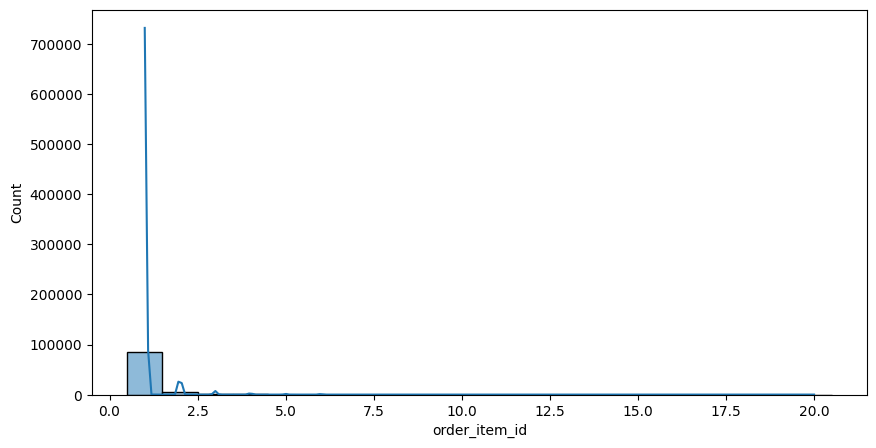

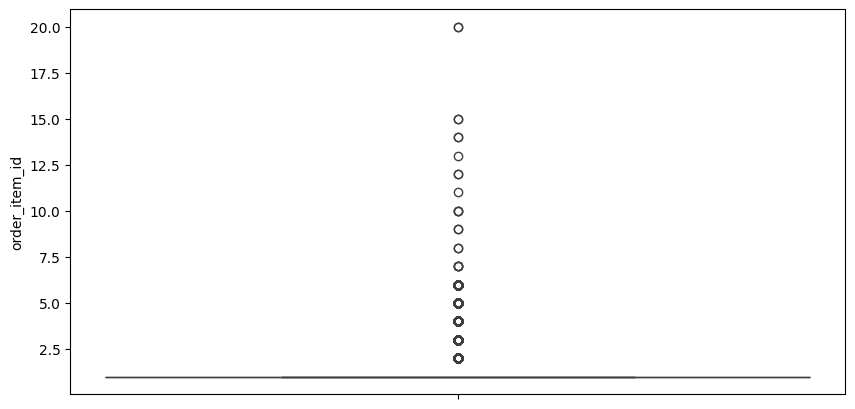

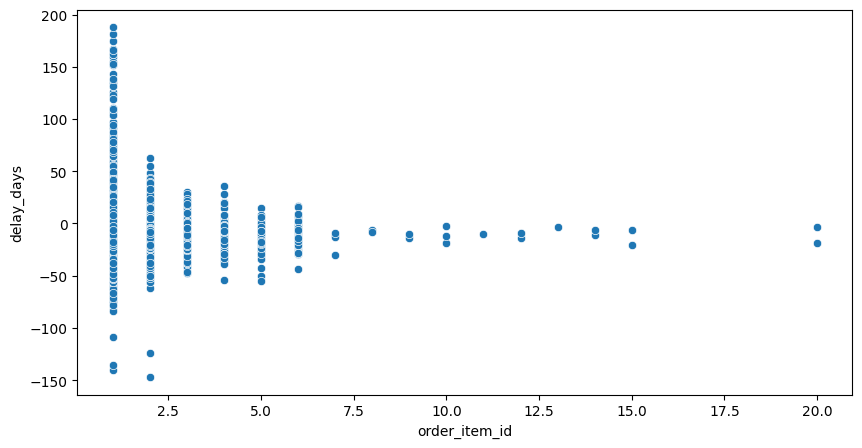

In [31]:
quick_viz_cat(df.order_item_id)

Hardly a relationship

**total price**

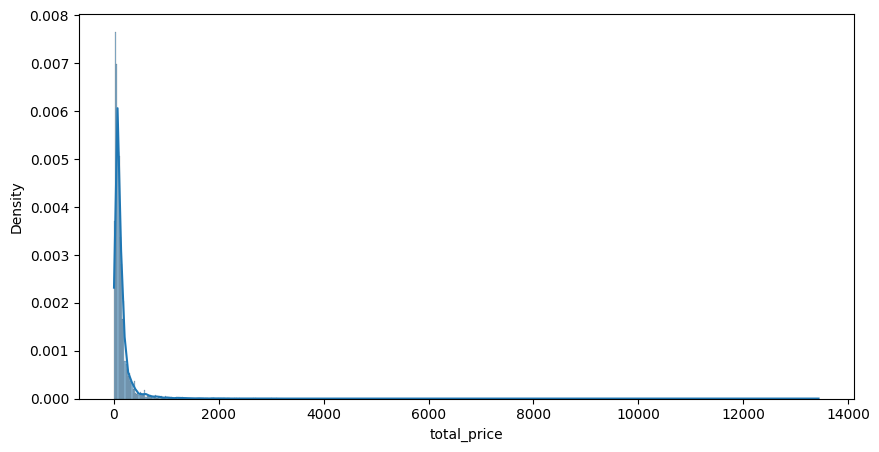

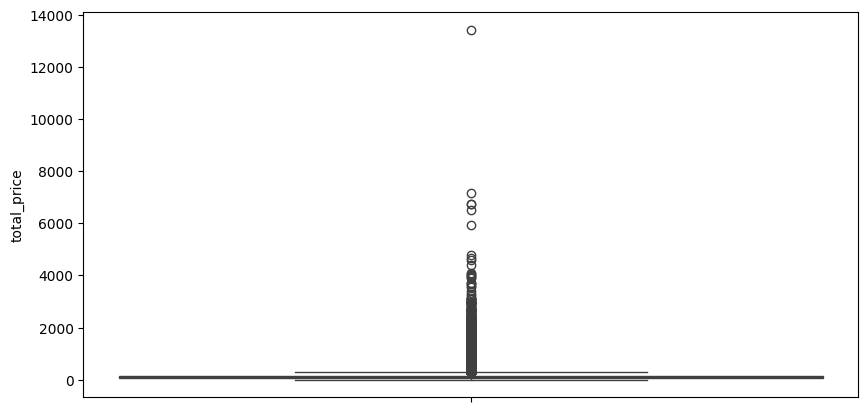

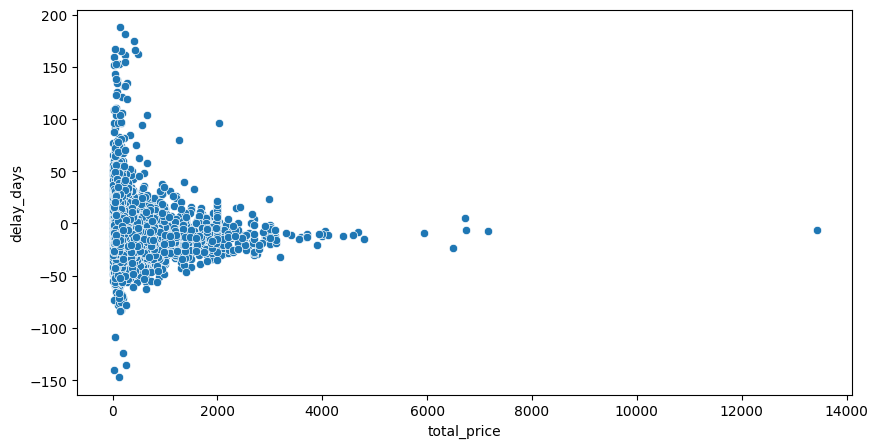

In [26]:
quick_viz(df.total_price)

Very skewed and likely some outliers. Clearly not a linear relationship with our target

> Could a log transform be useful?

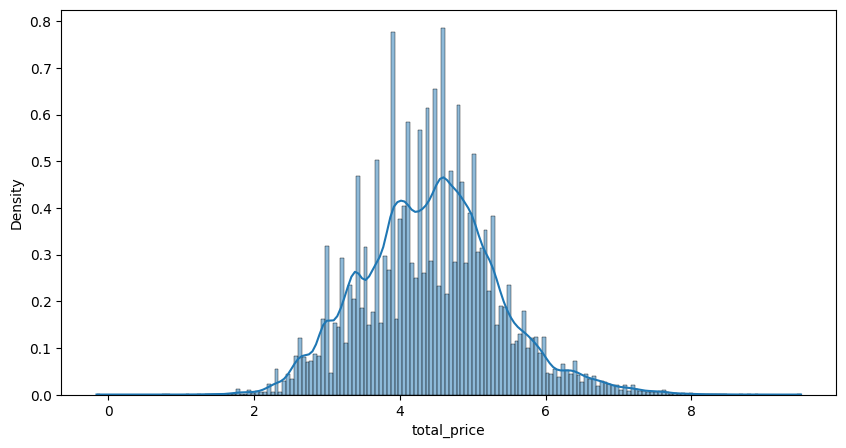

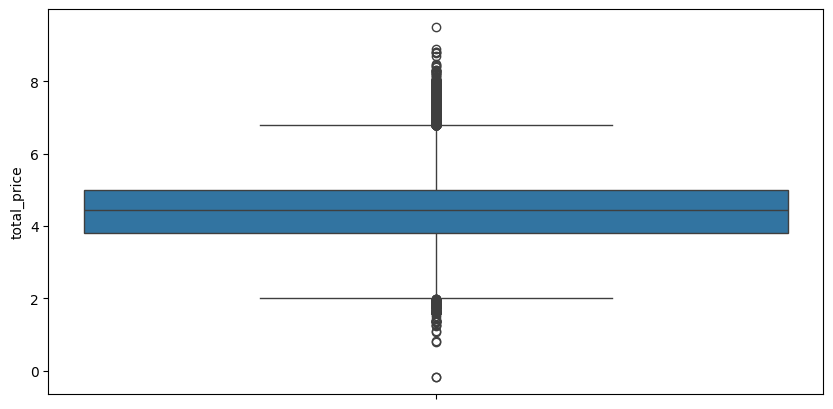

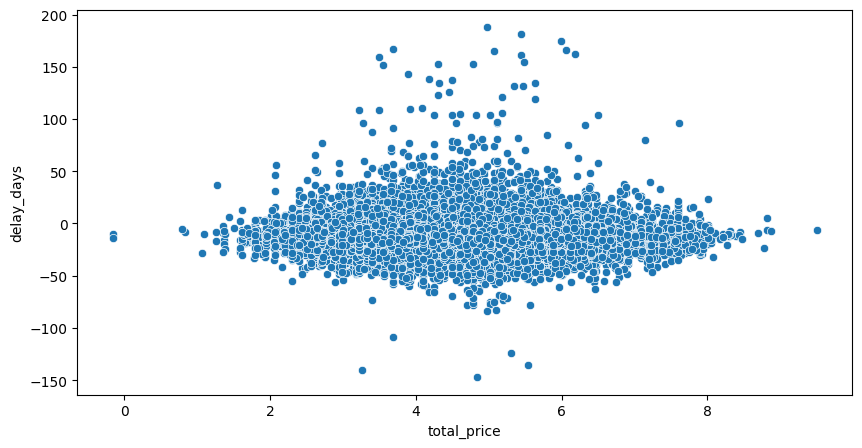

In [27]:
quick_viz(np.log(df.total_price))

Possibly better but we see that there is almost no relation between our feature and target. Let's add it for now

In [ ]:
df["total_price_log"] = np.log(df.total_price)

**total_freight**

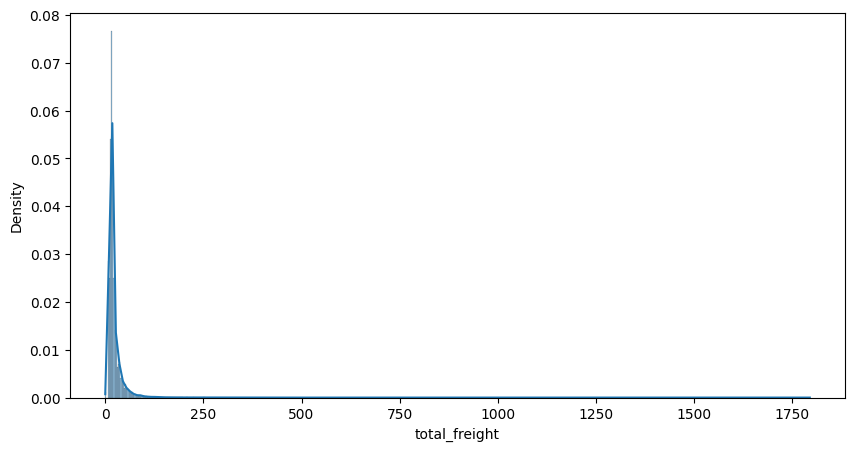

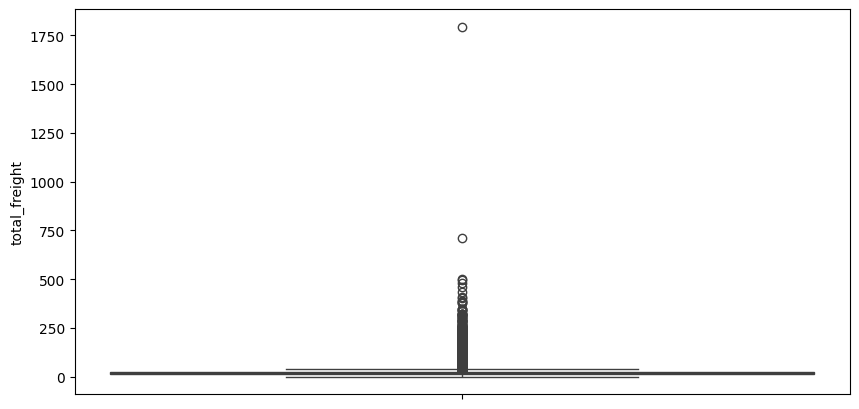

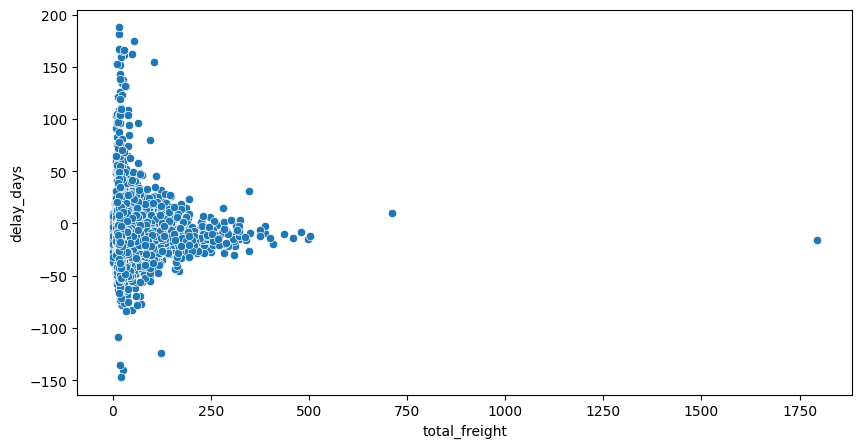

In [32]:
quick_viz(df.total_freight)

In [34]:
df.total_freight.describe()

count    91475.000000
mean        22.093803
std         20.363560
min          0.000000
25%         13.690000
50%         16.950000
75%         23.280000
max       1794.960000
Name: total_freight, dtype: float64

In [39]:
df[df["total_freight"]==0].head()

,delay_days,order_item_id,total_price,total_freight,order_value_check,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,...,seller_lng,cust_sell_distance_km,order_purchase_month,order_delivery_month,order_year_2016,order_year_2017,order_year_2018,delivery_year_2016,delivery_year_2017,delivery_year_2018
180,-21.0,2,139.8,0.0,139.8,1.0,0.0,1.0,0.0,0.0,...,-46.701883,481.457016,4,4,0,0,1,0,0,1
384,-29.0,1,99.9,0.0,99.9,1.0,0.0,1.0,0.0,0.0,...,-47.819418,516.103793,5,5,0,0,1,0,0,1
595,-4.0,1,69.9,0.0,69.9,1.0,1.0,0.0,0.0,0.0,...,-46.701883,852.595287,5,6,0,0,1,0,0,1
613,-13.0,1,110.0,0.0,110.0,1.0,0.0,1.0,0.0,0.0,...,-47.819418,2122.402326,5,5,0,0,1,0,0,1
800,-16.0,1,69.9,0.0,69.9,1.0,0.0,1.0,0.0,0.0,...,-46.701883,328.079227,4,5,0,0,1,0,0,1


We seem to have an issue where our total freight is equal to 0 in some places. We will leave it as it could contain important information but this means that we can't use the log transform

**order_value_check**

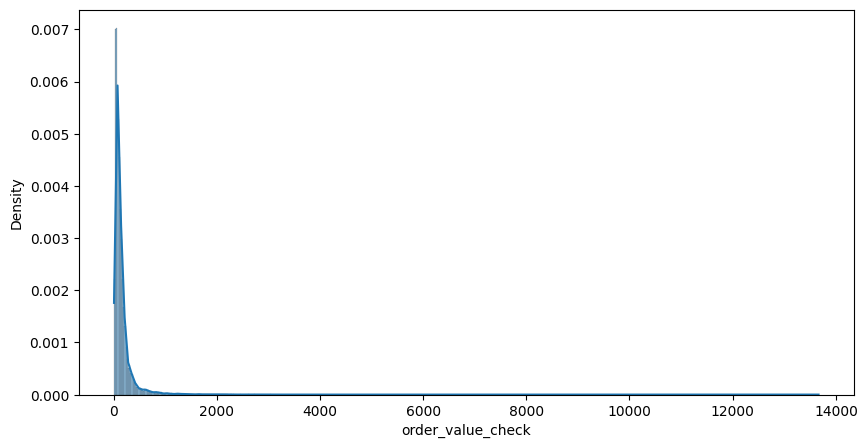

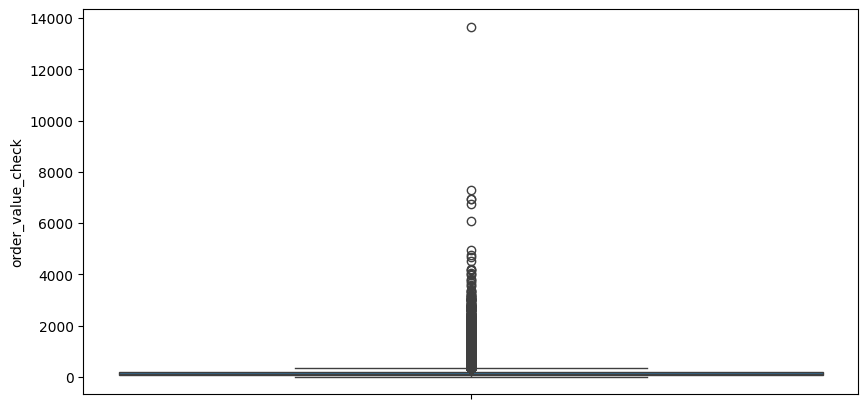

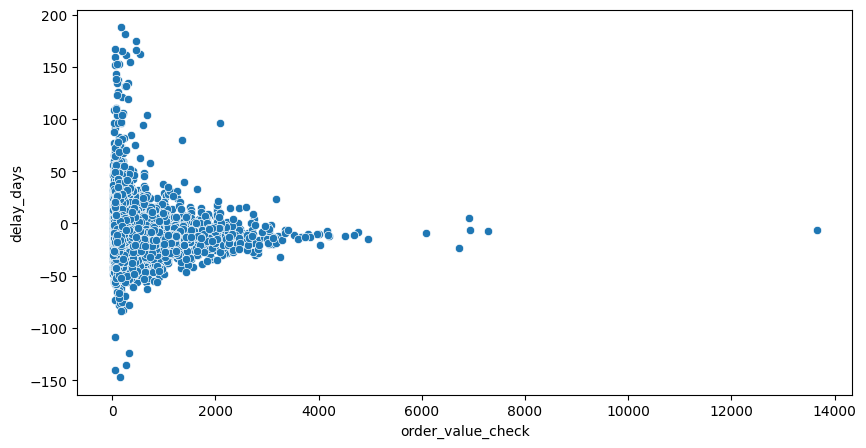

In [40]:
quick_viz(df.order_value_check)

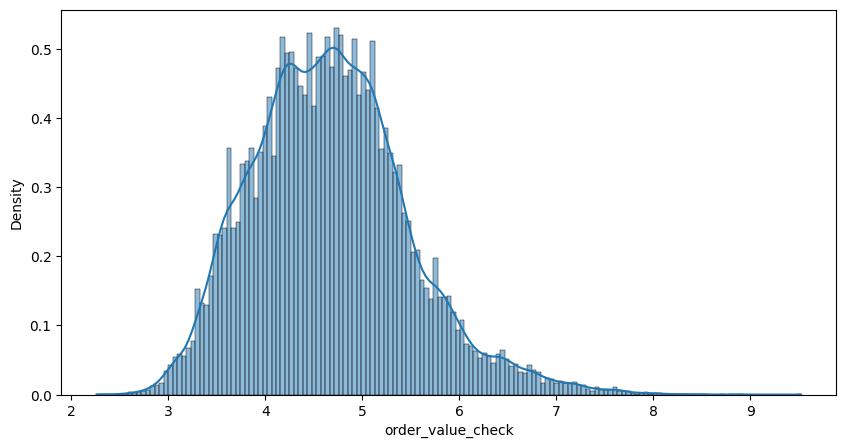

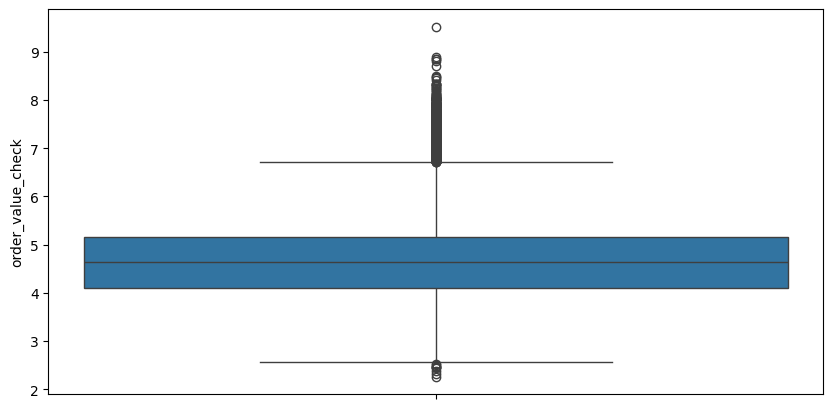

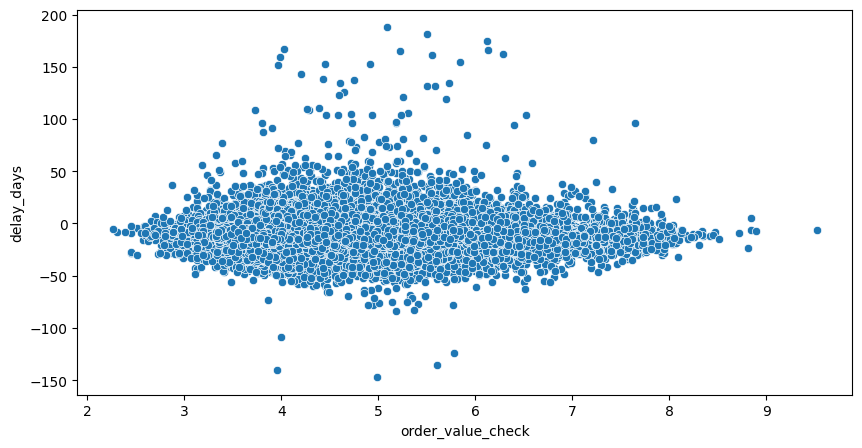

In [41]:
quick_viz(np.log(df.order_value_check))

> We could try a Robust Scaler as well to account for the outliers

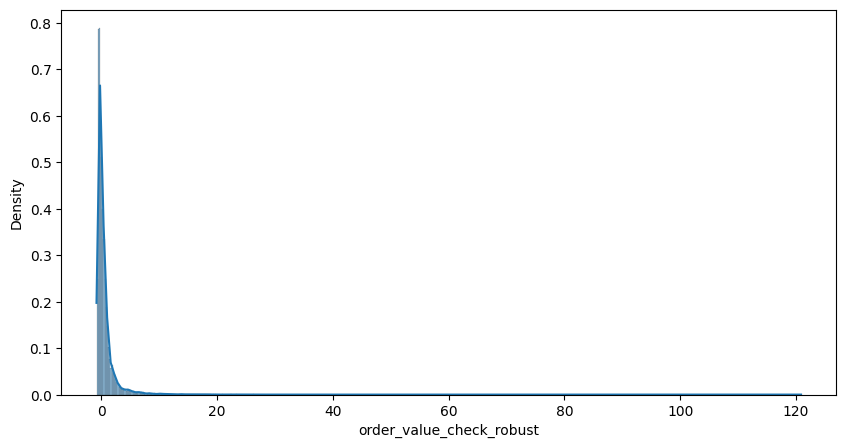

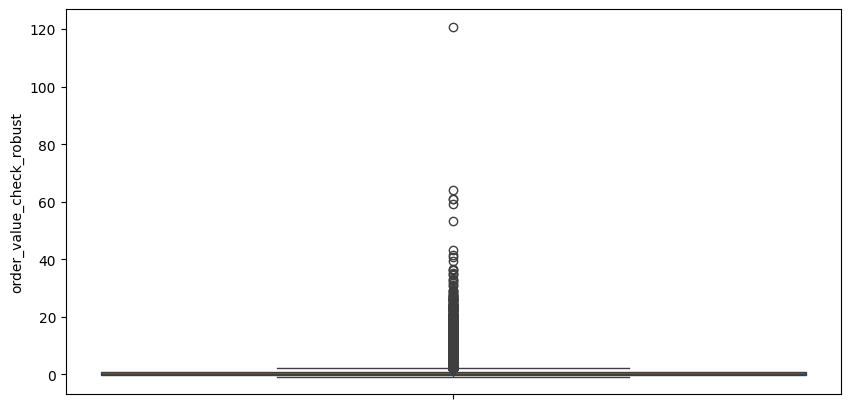

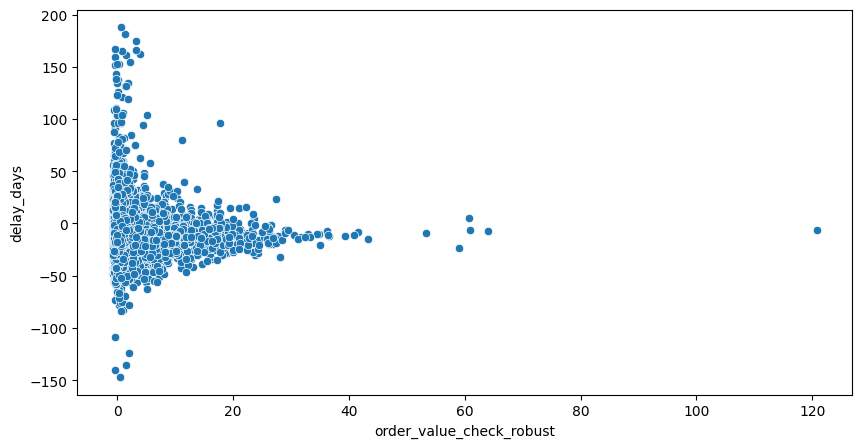

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df["order_value_check_robust"] = scaler.fit_transform(df[["order_value_check"]])

quick_viz(df.order_value_check_robust)

Doesn't seem to have helped

In [ ]:
df = df.drop(columns = ["order_value_check_robust"])

df["order_value_check_log"] = np.log(df.order_value_check)

In [54]:
df.info() # quick check to see if everything is good so far

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   delay_days                     91475 non-null  float64 
 1   order_item_id                  91475 non-null  int64   
 2   total_price                    91475 non-null  float64 
 3   total_freight                  91475 non-null  float64 
 4   order_value_check              91475 non-null  float64 
 5   is_payment_sequential_1        91475 non-null  float64 
 6   payment_type_boleto            91475 non-null  float64 
 7   payment_type_credit_card       91475 non-null  float64 
 8   payment_type_debit_card        91475 non-null  float64 
 9   payment_type_voucher           91475 non-null  float64 
 10  installments_boleto            91475 non-null  float64 
 11  installments_credit_card       91475 non-null  float64 
 12  installments_debit_card        9

**is_payment_sequential_1**

In [56]:
df.is_payment_sequential_1.nunique()

2

In [60]:
df.is_payment_sequential_1.value_counts()

is_payment_sequential_1
True     89995
False     1480
Name: count, dtype: int64

In [57]:
df["is_payment_sequential_1"] = df["is_payment_sequential_1"].astype(bool) # to make it more clean

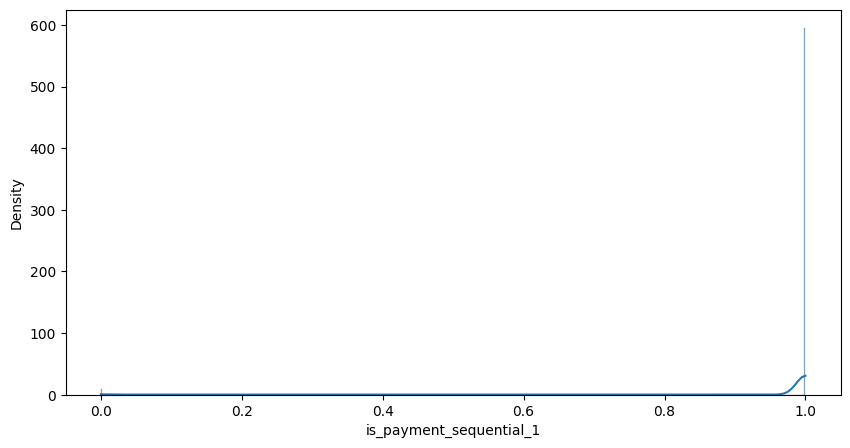

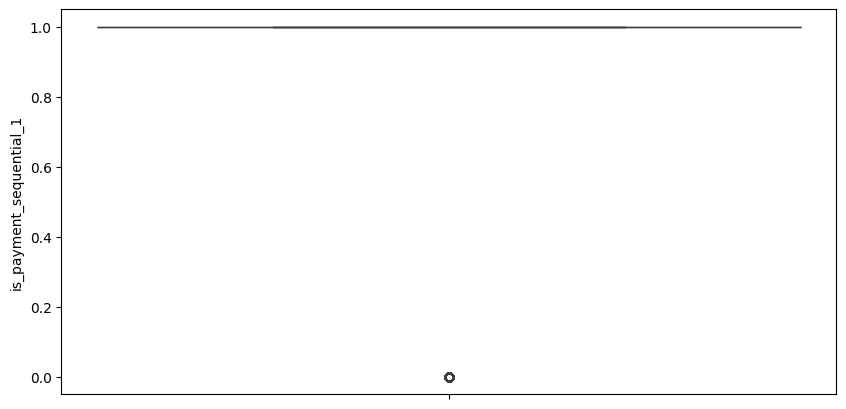

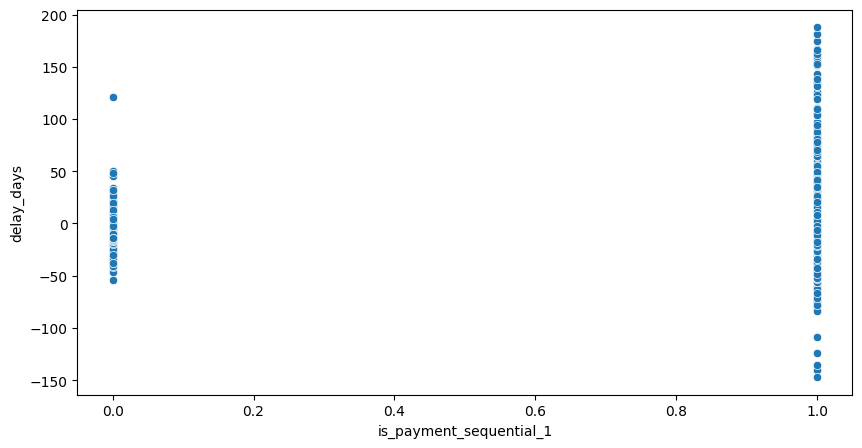

In [58]:
quick_viz(df.is_payment_sequential_1)

> This is very unbalanced - we may require a stratified - k fold approach in CV later. Either we can't say much about this variable or it's clear that if an order was paid for with many methods, then we experience more extreme delays.

**payment_type_boleto**

In [61]:
df.payment_type_boleto.nunique()

2

In [62]:
df["payment_type_boleto"] = df["payment_type_boleto"].astype(bool) # to make it more clean

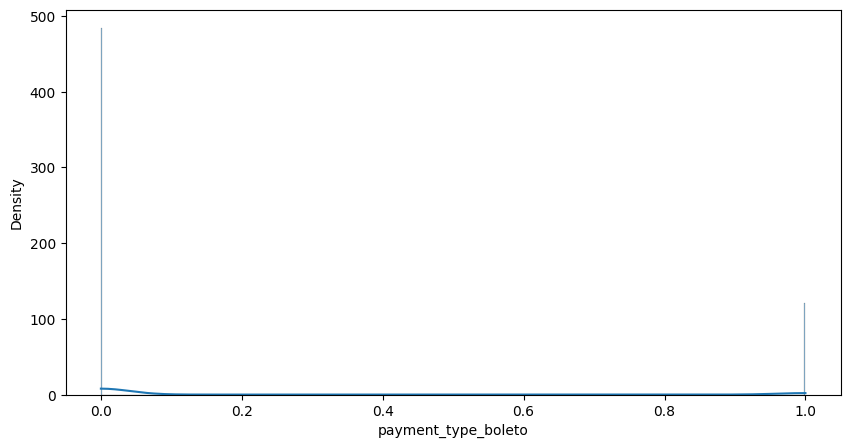

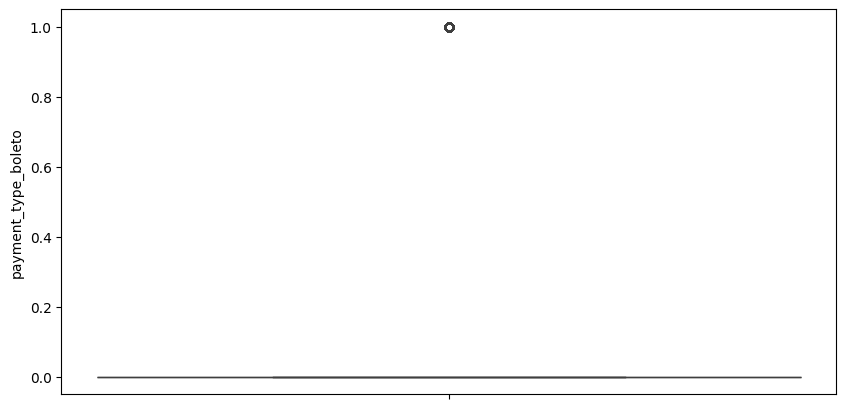

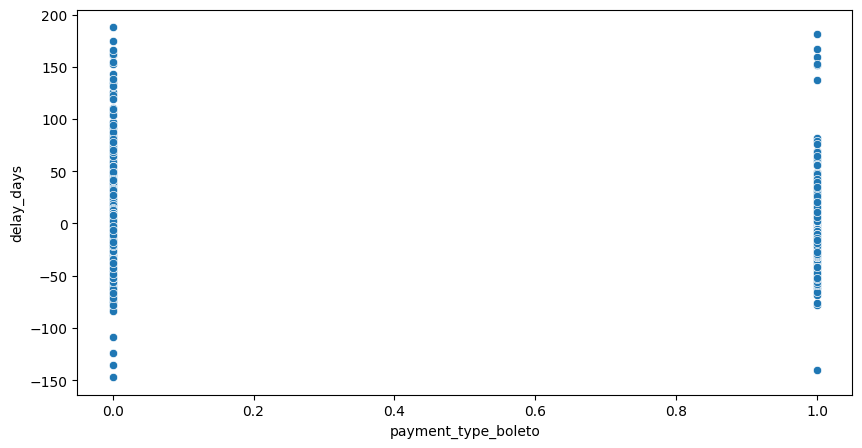

In [63]:
quick_viz(df.payment_type_boleto)

Again, not much to say here

**payment_type_credit_card**

In [ ]:
df.payment_type_credit_card.nunique()

2

In [67]:
df["payment_type_credit_card"] = df["payment_type_credit_card"].astype(bool) # to make it more clean

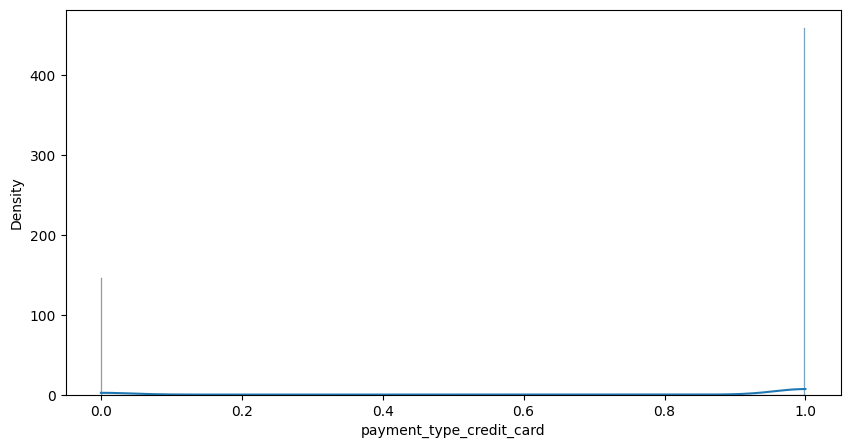

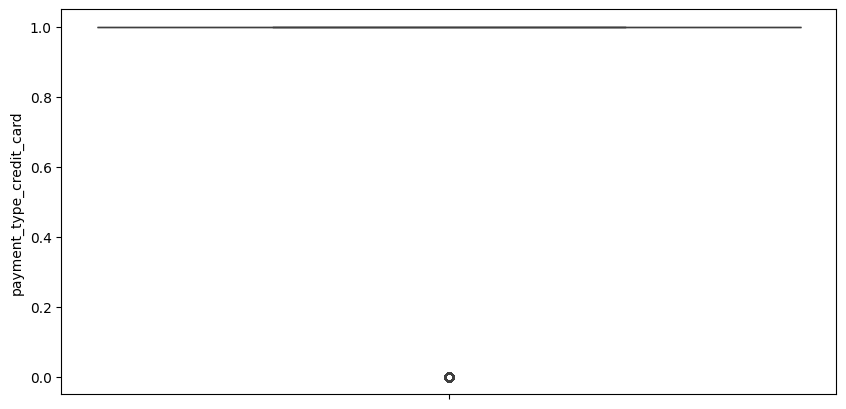

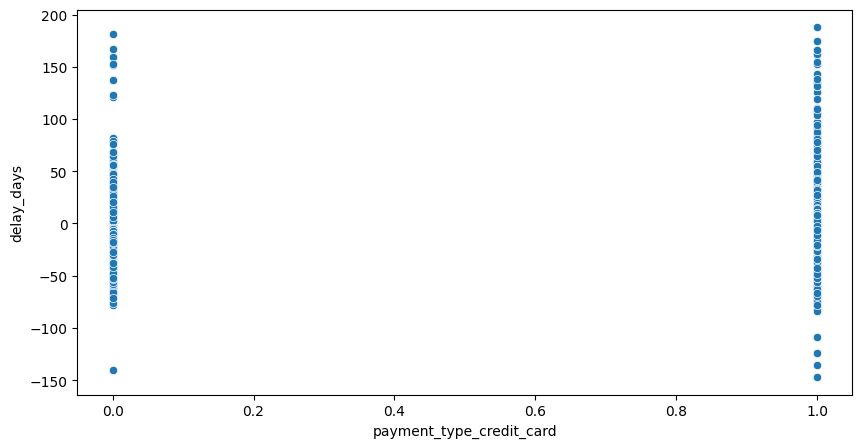

In [68]:
quick_viz(df.payment_type_credit_card)

In [77]:
df.payment_type_credit_card.value_counts()

payment_type_credit_card
True     69351
False    22124
Name: count, dtype: int64

Similar situation here as well

**payment_type_debit_card**

In [69]:
df.payment_type_debit_card.nunique()

2

In [70]:
df["payment_type_debit_card"] = df["payment_type_debit_card"].astype(bool) # to make it more clean

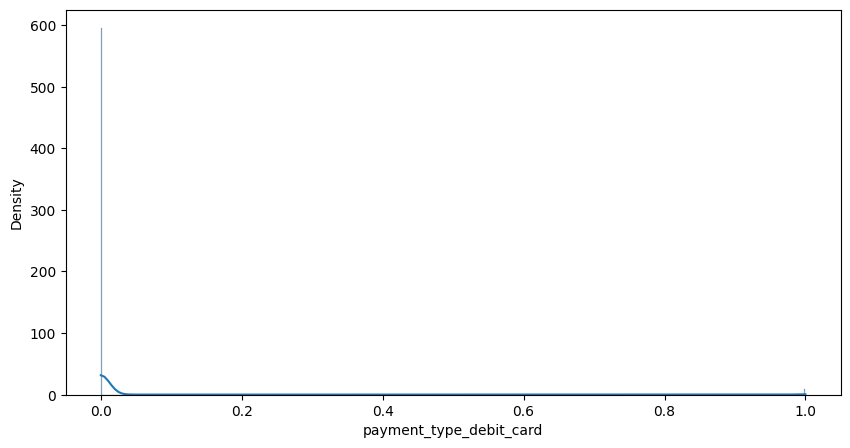

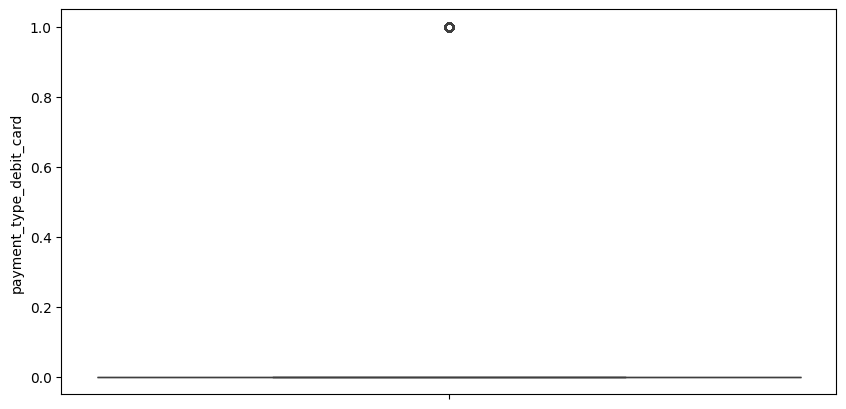

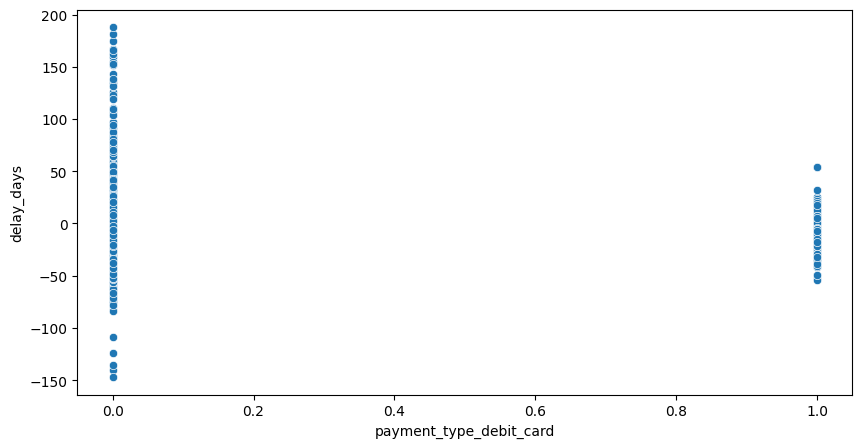

In [71]:
quick_viz(df.payment_type_debit_card)

> Smaller delays when the order is paid by debit card?

**payment_type_voucher**

In [72]:
df.payment_type_voucher.nunique()

2

In [73]:
df["payment_type_voucher"] = df["payment_type_voucher"].astype(bool) # to make it more clean

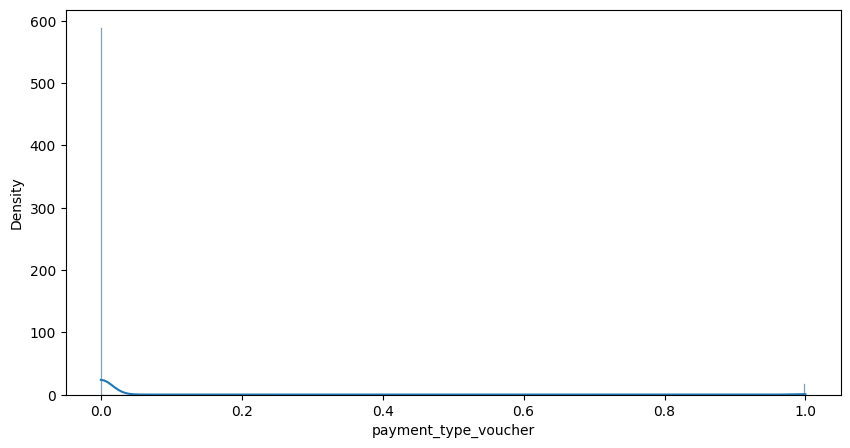

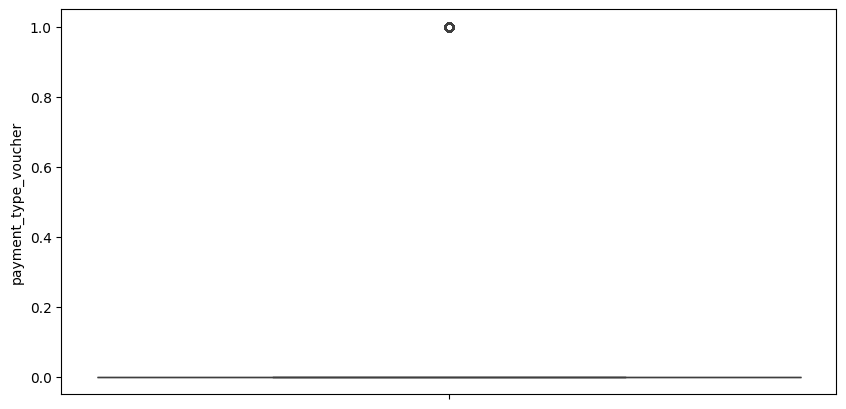

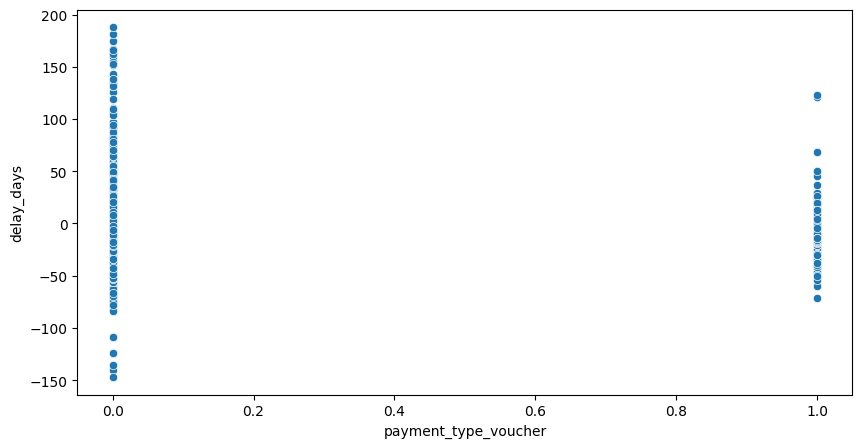

In [75]:
quick_viz(df.payment_type_voucher)

In [76]:
df.payment_type_voucher.value_counts()

payment_type_voucher
False    89024
True      2451
Name: count, dtype: int64

Similarily to the previous variable but we also have to keep in mind that this is imbalanced

**installments_boleto**

In [78]:
df.installments_boleto.nunique()

2

In [79]:
df.installments_boleto.value_counts()

installments_boleto
0.0    73204
1.0    18271
Name: count, dtype: int64

In [82]:
df["installments_boleto"] = df["installments_boleto"].astype(int) # to make it more clean

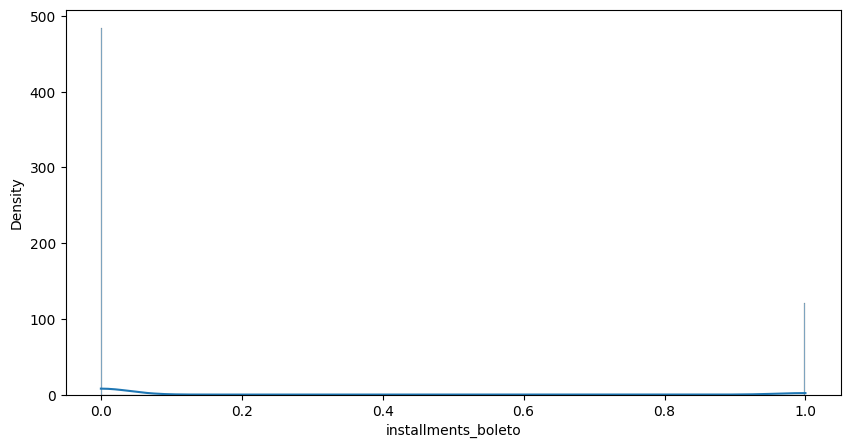

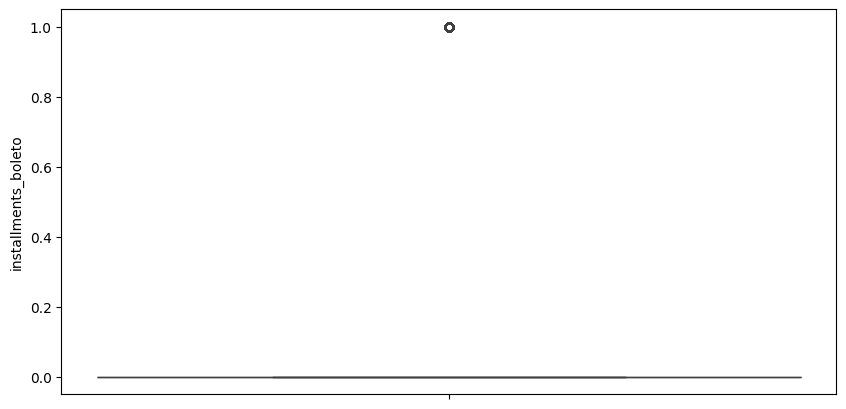

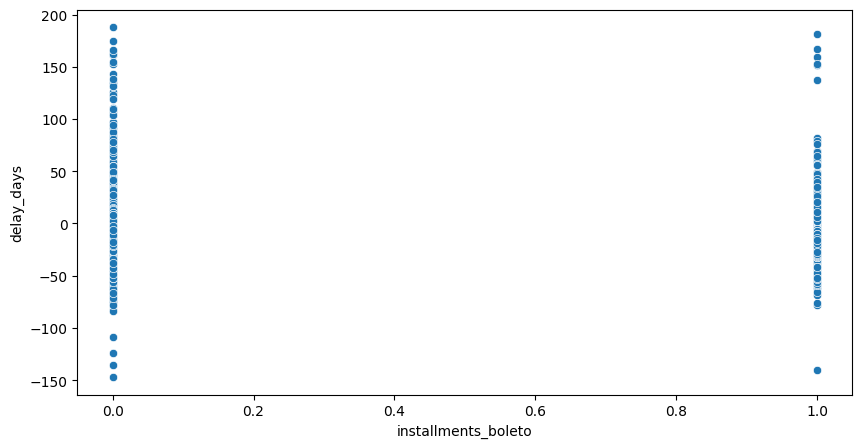

In [84]:
quick_viz(df.installments_boleto)

Very similar behaviour

**installments_credit_card**

In [85]:
df.installments_credit_card.nunique()

24

In [86]:
df["installments_credit_card"] = df["installments_credit_card"].astype(int) # to make it more clean

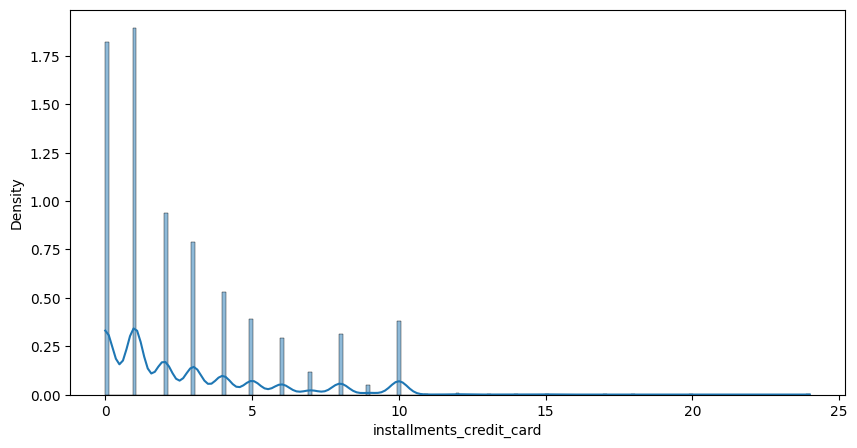

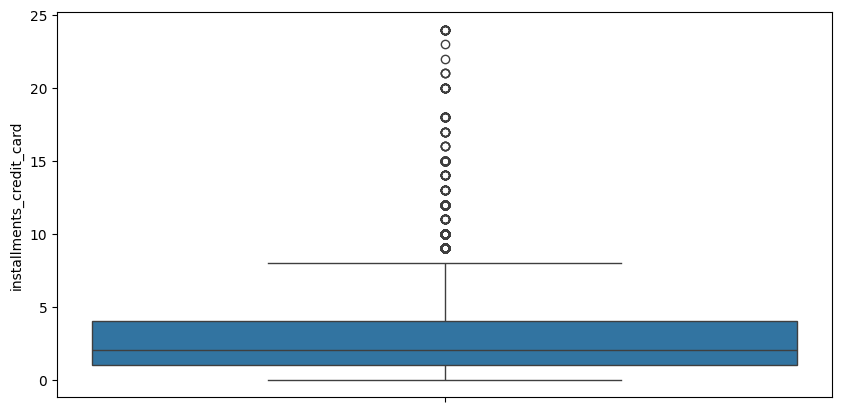

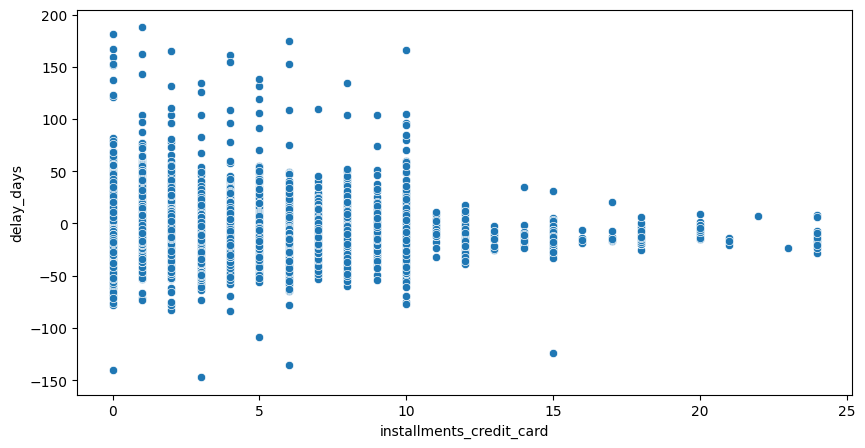

In [87]:
quick_viz(df.installments_credit_card)

In [88]:
df.installments_credit_card.value_counts()

installments_credit_card
1     22986
0     22126
2     11363
3      9557
4      6450
5      4735
10     4630
8      3792
6      3521
7      1445
9       576
12      112
15       66
18       25
11       19
24       15
20       14
13       14
14       13
17        7
16        4
21        3
23        1
22        1
Name: count, dtype: int64

**installments_debit_card**

In [89]:
df.installments_debit_card.nunique()

2

In [91]:
df["installments_debit_card"] = df["installments_debit_card"].astype(int) # to make it more clean

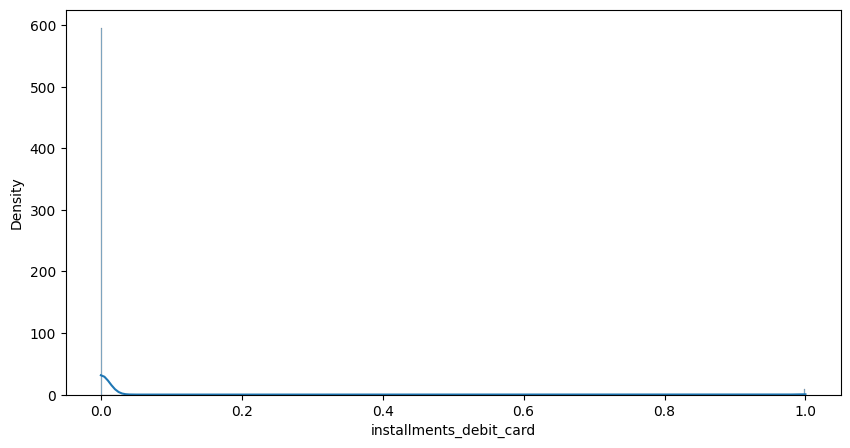

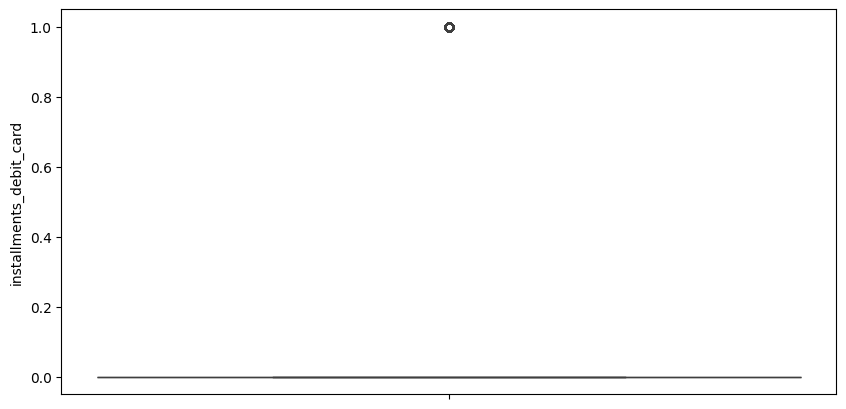

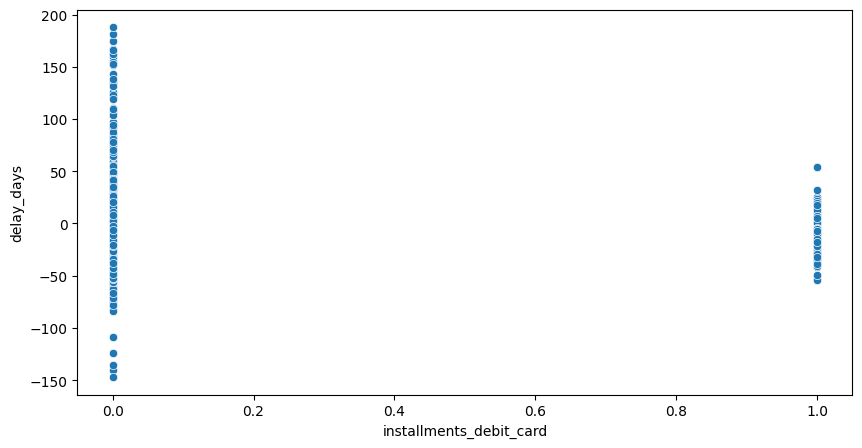

In [92]:
quick_viz(df.installments_debit_card)

**isnstallments_voucher**

In [93]:
df.installments_voucher.nunique()

2

In [94]:
df["installments_voucher"] = df["installments_voucher"].astype(int) # to make it more clean

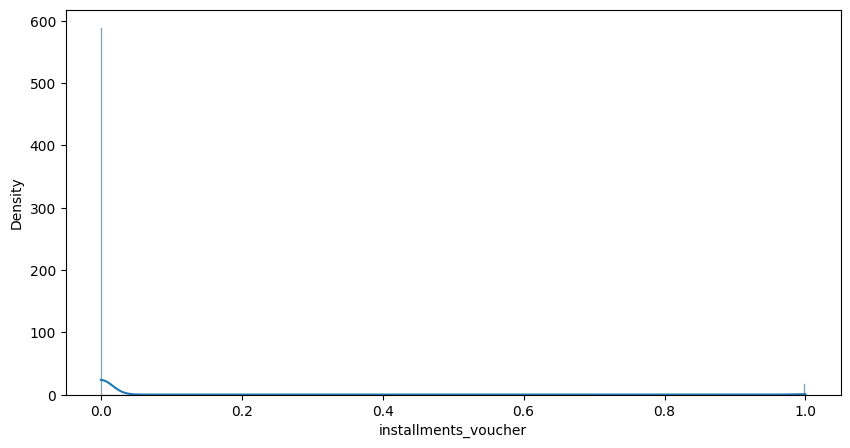

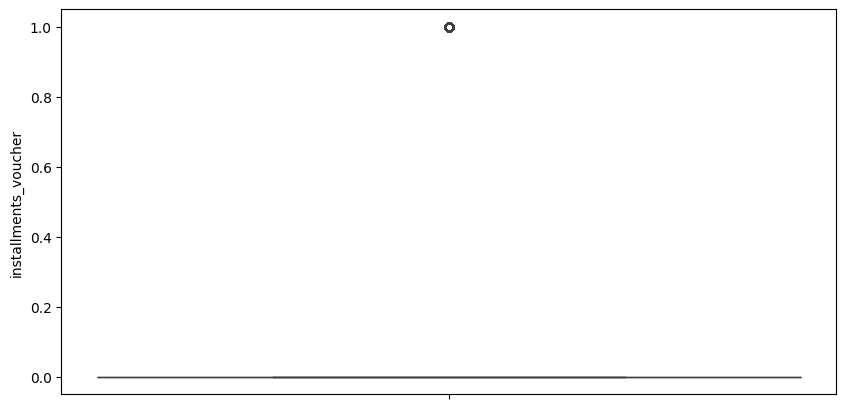

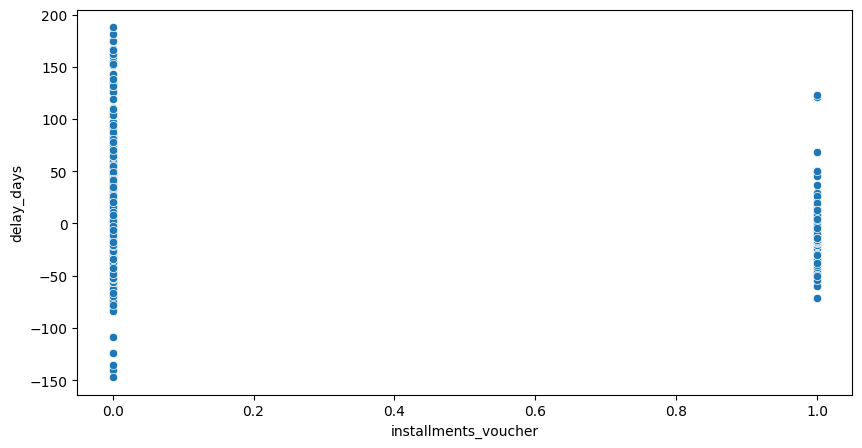

In [95]:
quick_viz(df.installments_voucher)

**product_name_lenght**

Let's fix the typo first

In [98]:
df.rename(columns={"product_name_lenght": "product_name_length"}, inplace=True)

In [102]:
df.product_name_length.nunique()

64

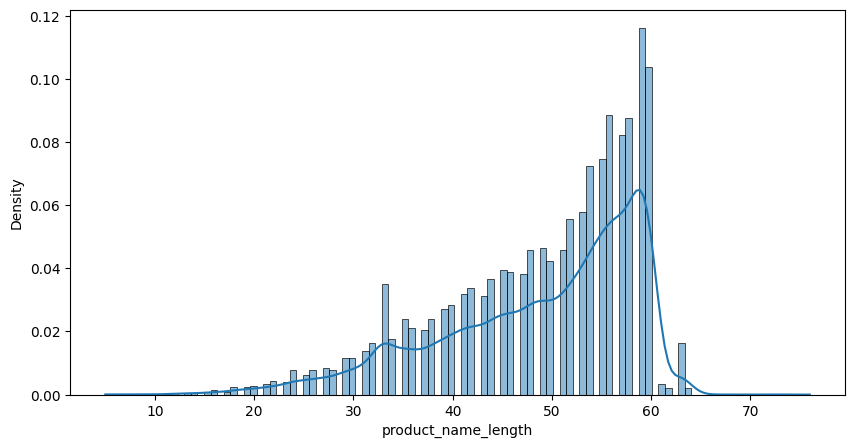

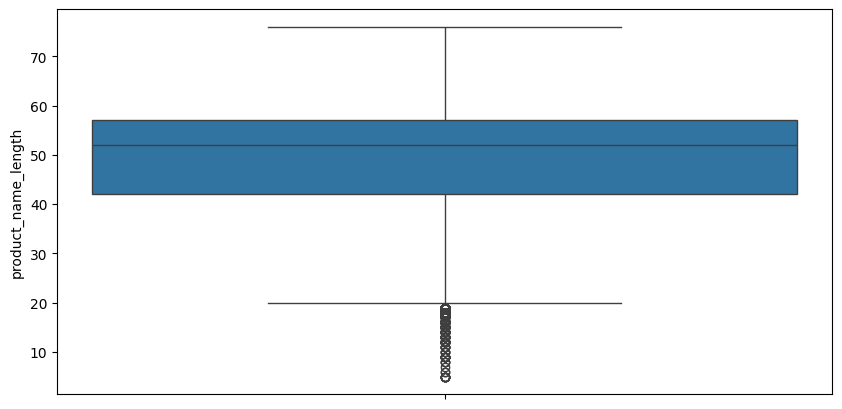

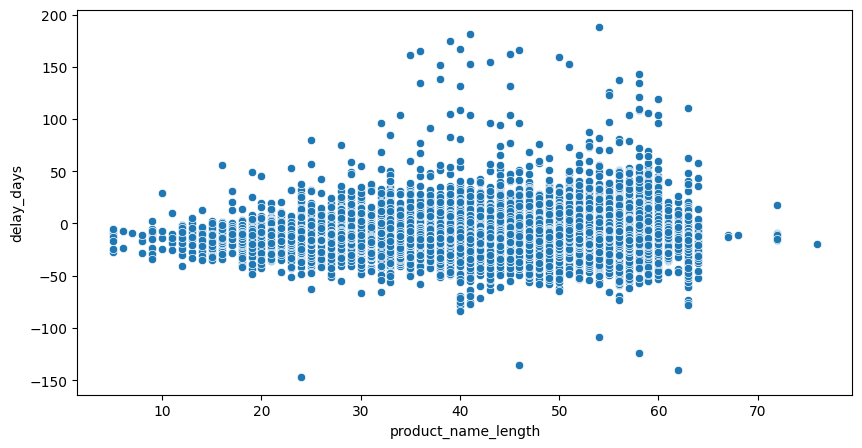

In [106]:
quick_viz(df.product_name_length)

The relationship seems vague again

**product_description_lenght**

In [110]:
df.rename(columns={"product_description_lenght": "product_description_length"}, inplace=True)

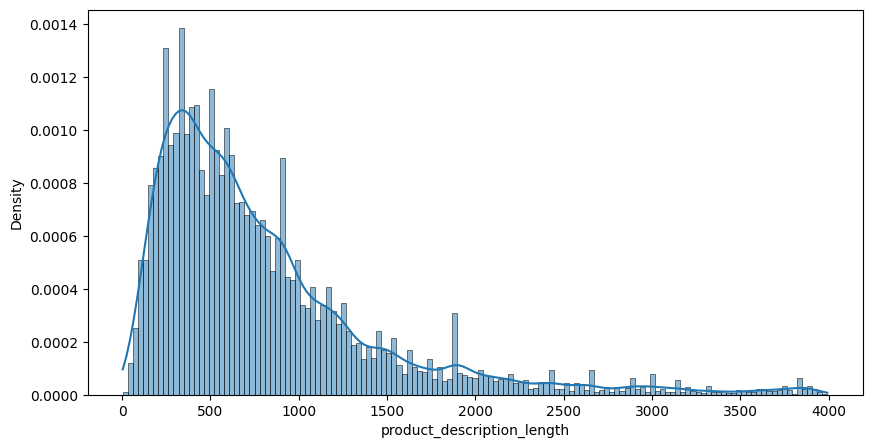

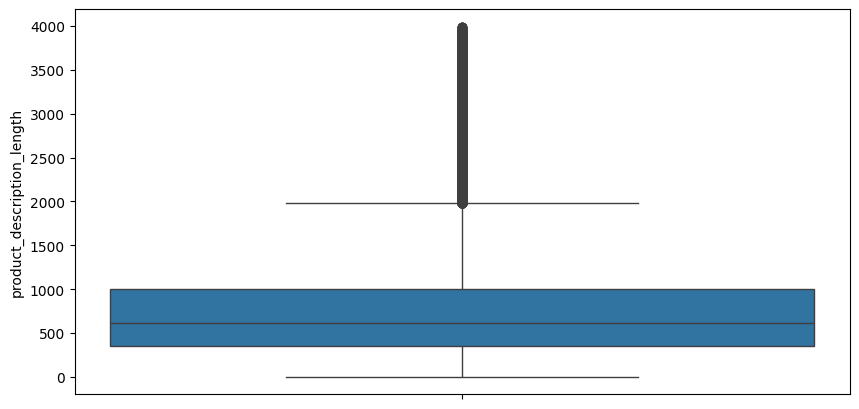

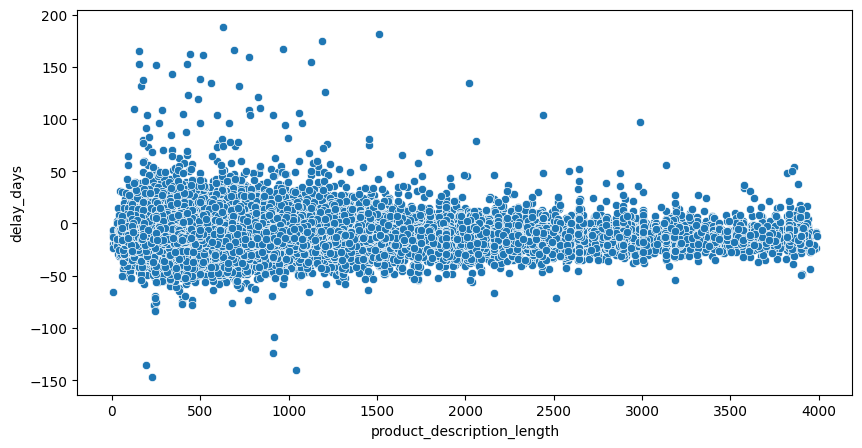

In [112]:
quick_viz(df.product_description_length)

**product_photos_qty**

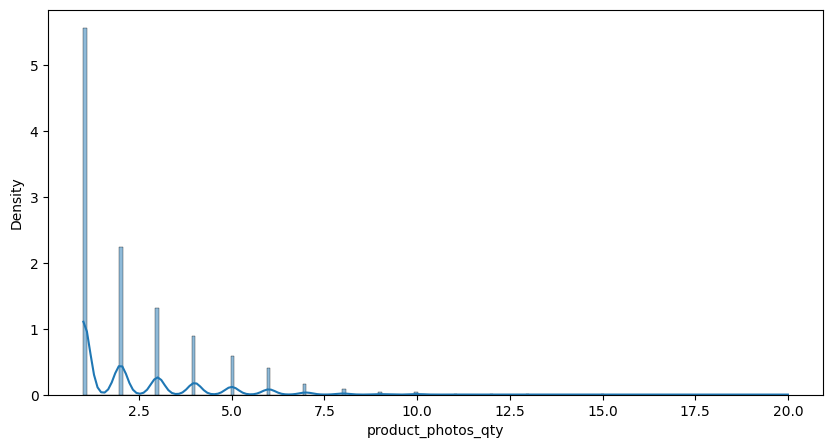

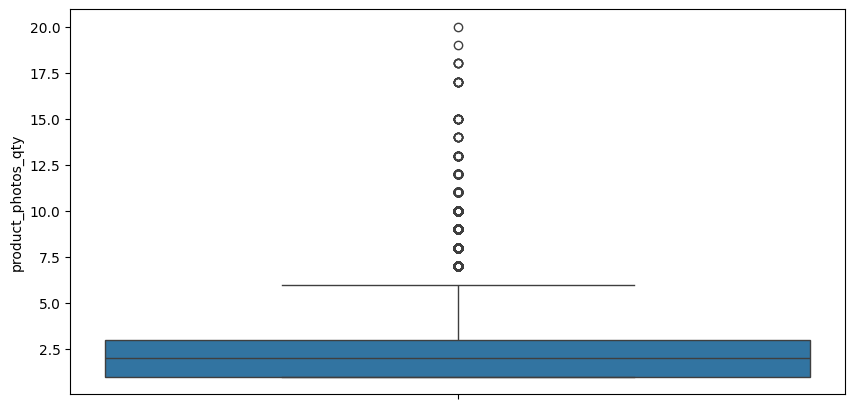

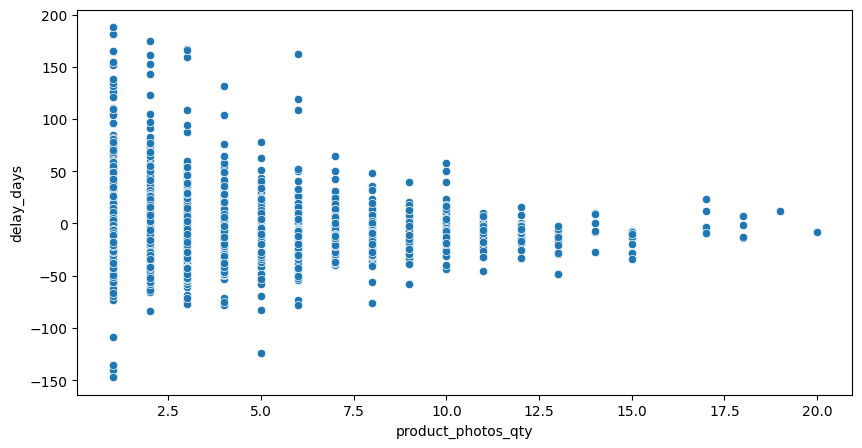

In [113]:
quick_viz(df.product_photos_qty)

In [114]:
df["product_photos_qty"] = df["product_photos_qty"].astype(int) # to make it more clean

**product_weight_g**

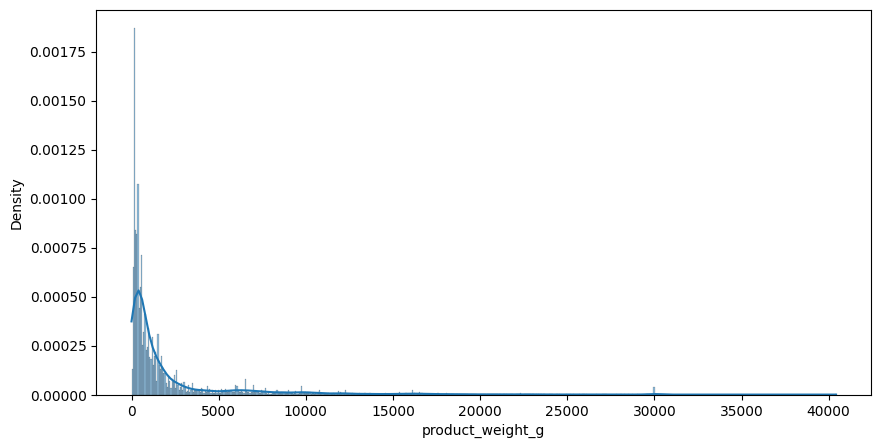

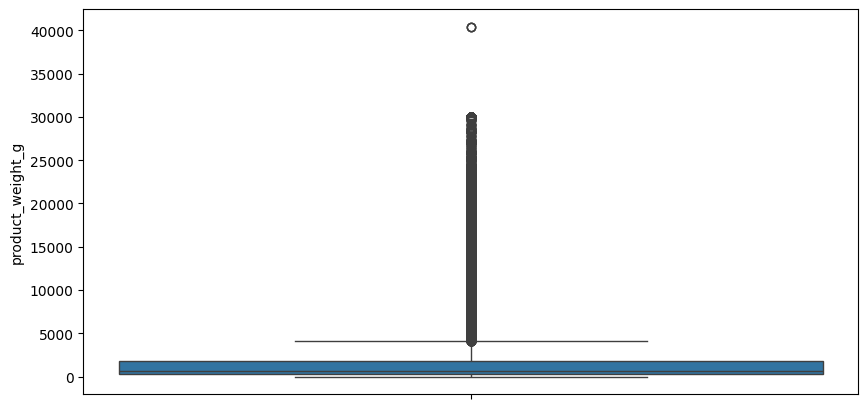

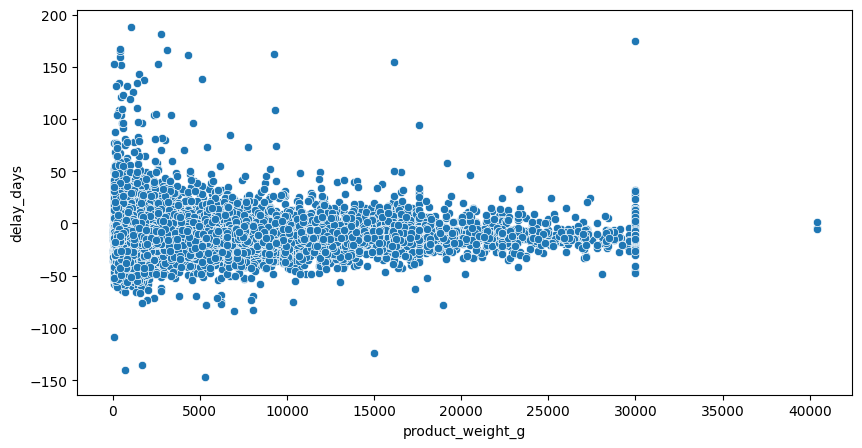

In [115]:
quick_viz(df.product_weight_g)

The relationship remains unclear

**product_length_cm**

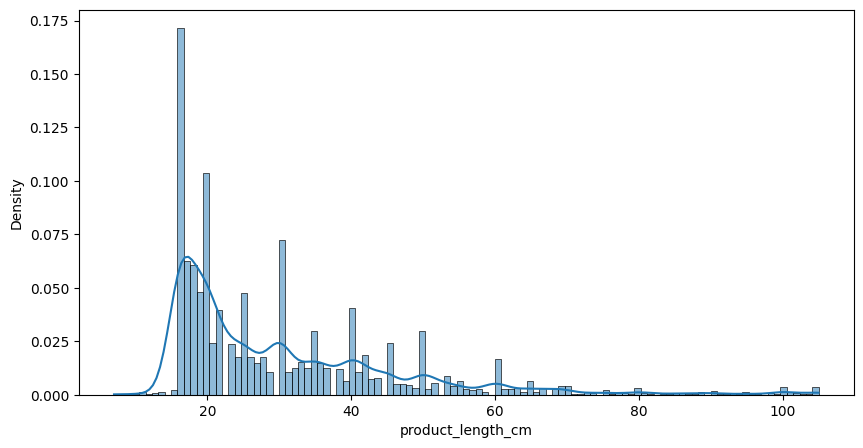

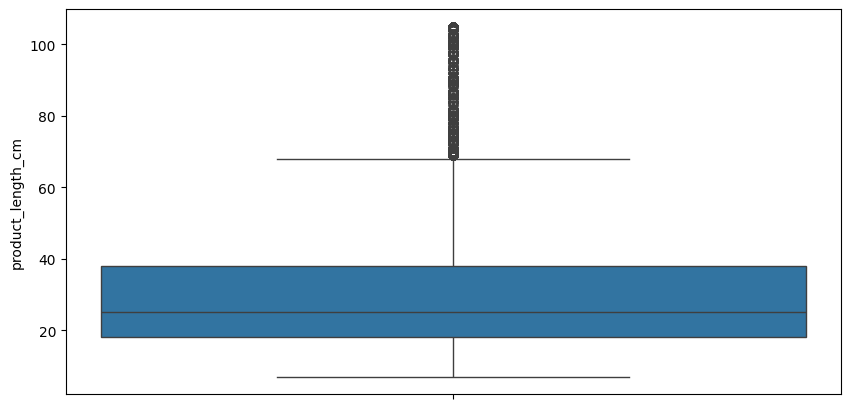

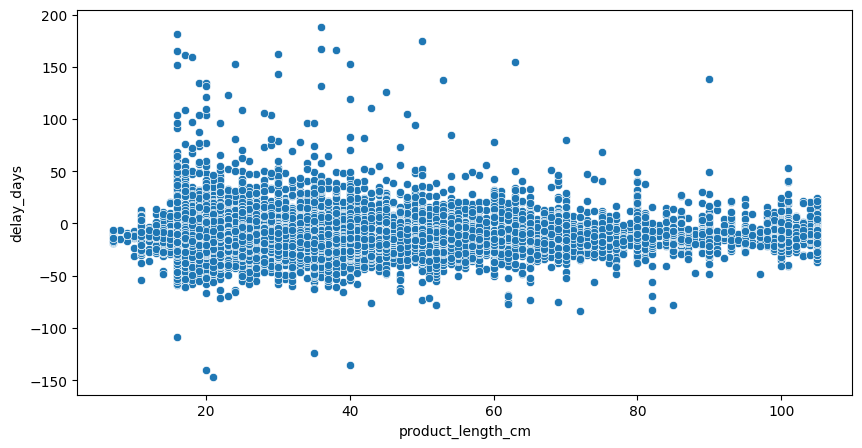

In [116]:
quick_viz(df.product_length_cm)

**product_height_cm**

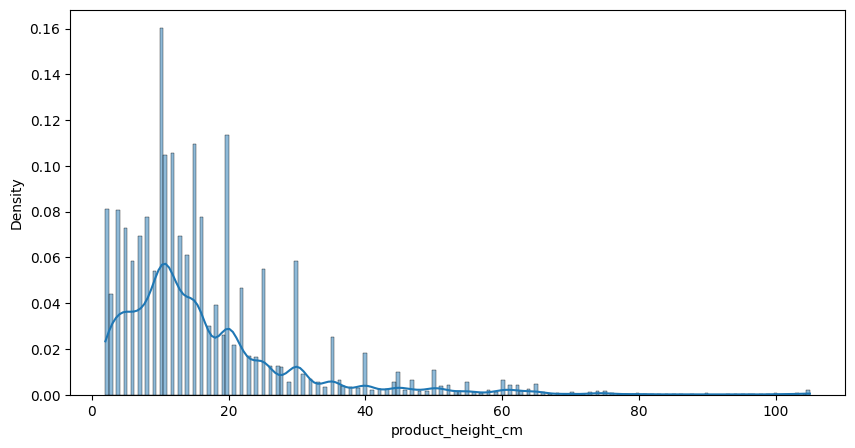

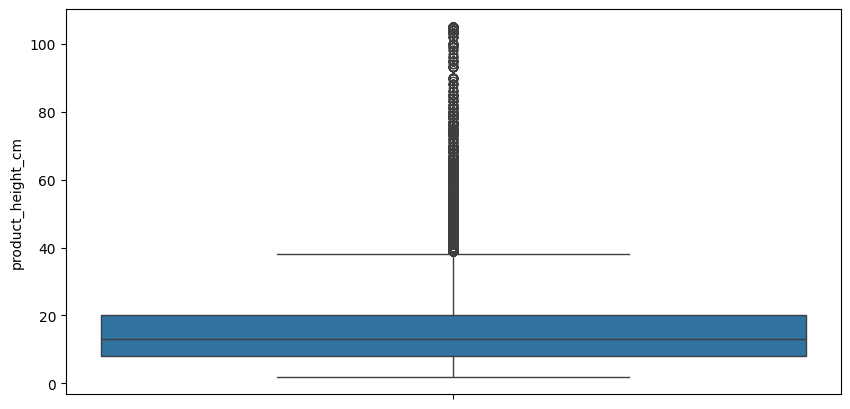

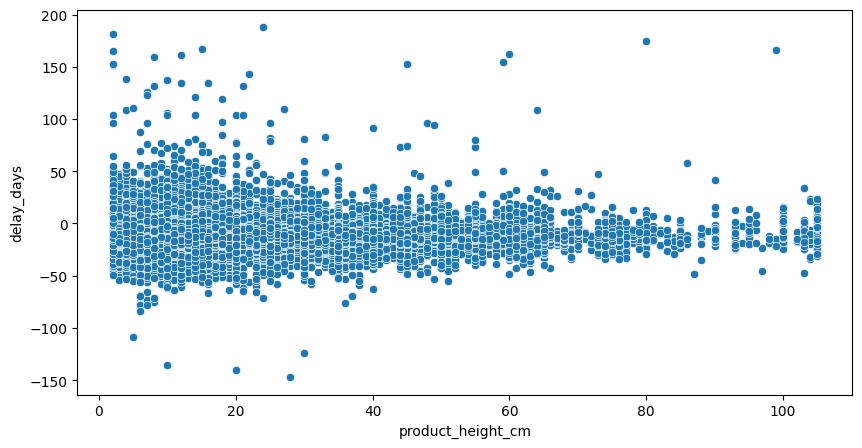

In [117]:
quick_viz(df.product_height_cm)

**product_width_cm**

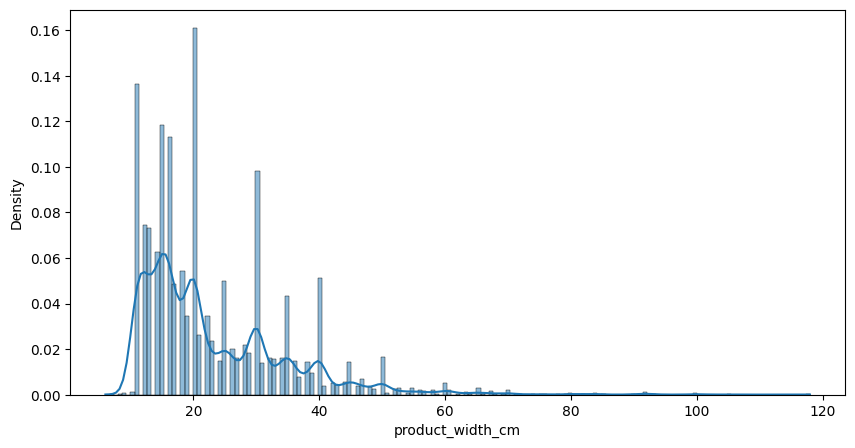

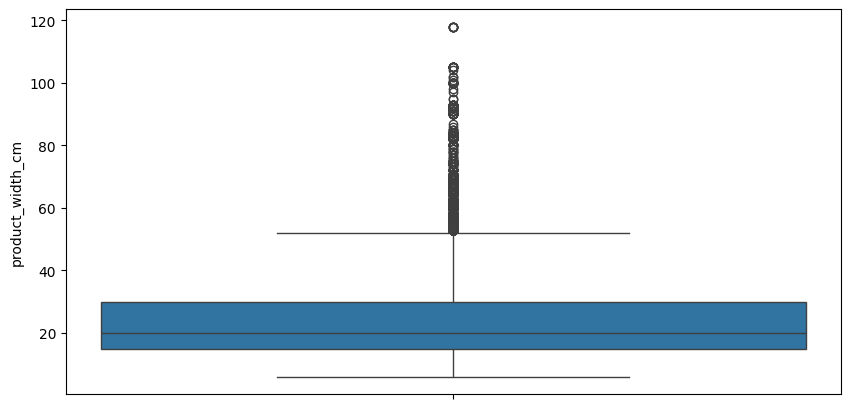

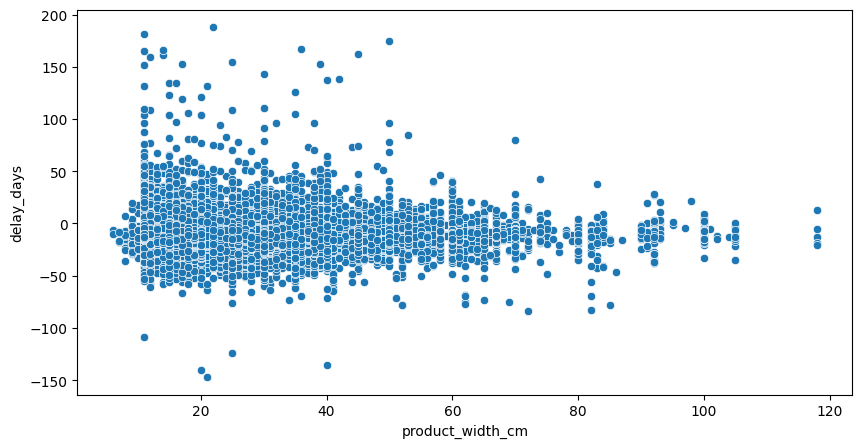

In [118]:
quick_viz(df.product_width_cm)

**product_category_name_english**

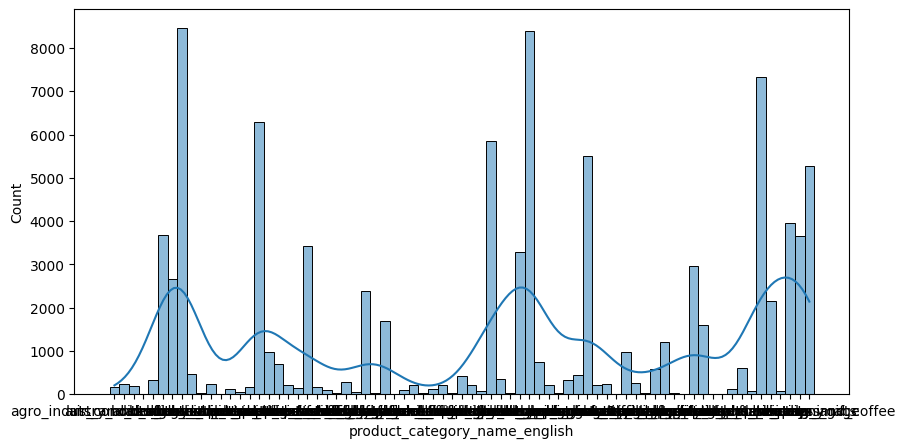

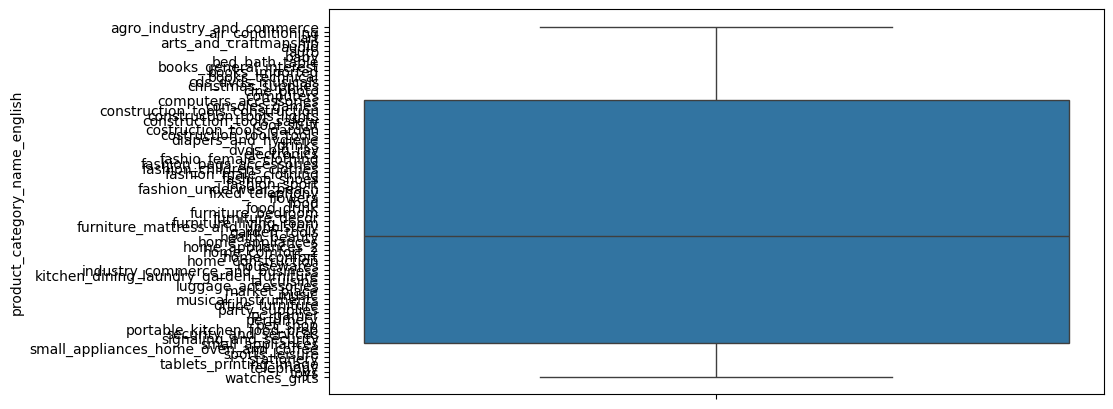

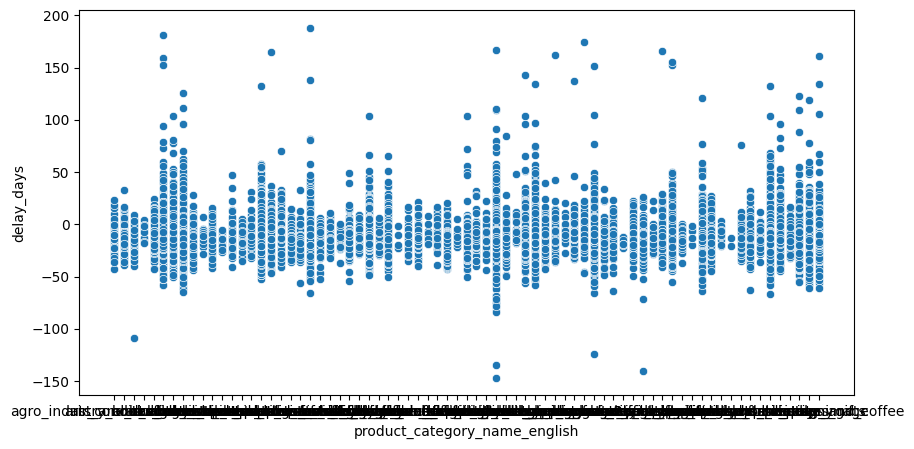

In [119]:
quick_viz_cat(df.product_category_name_english)

**seller_state**

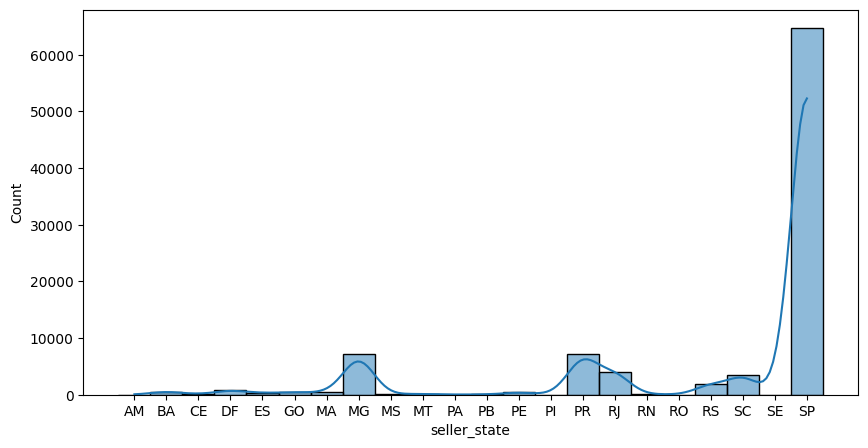

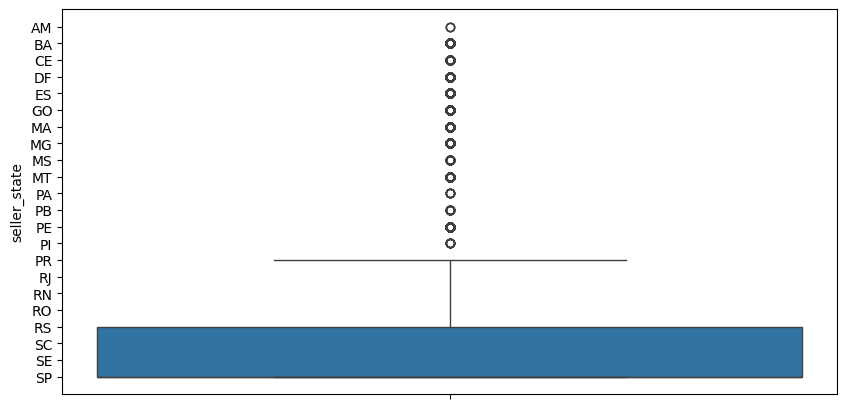

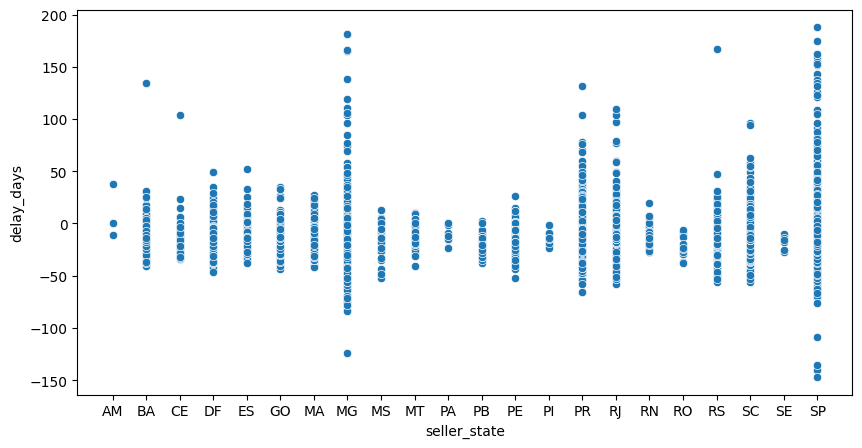

In [121]:
quick_viz_cat(df.seller_state)

**customer_state**

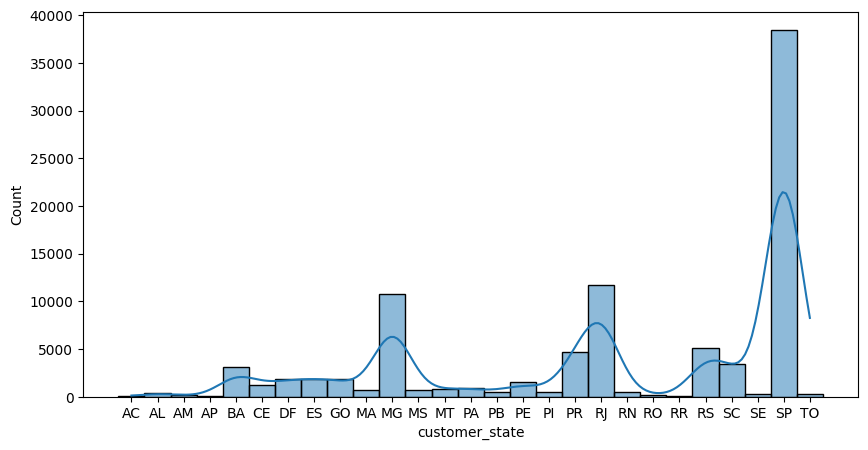

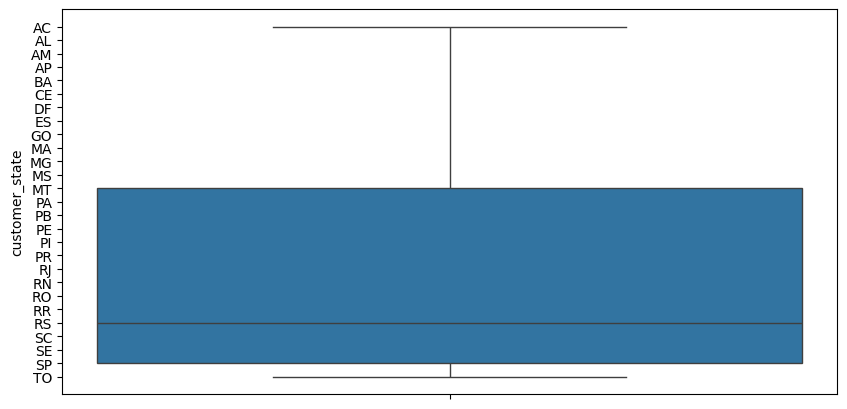

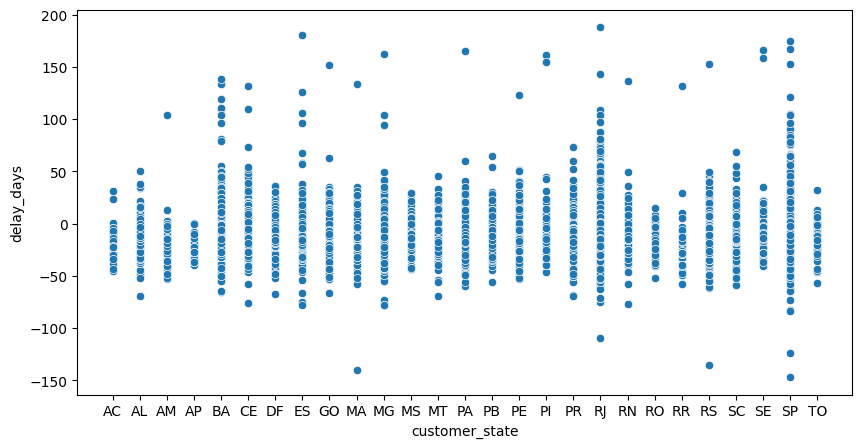

In [122]:
quick_viz_cat(df.customer_state)

We see the difference in behaviour (compared to seller_state) for the state MG, for example

**cust_sell_same_state**

In [123]:
df.cust_sell_same_state.nunique()

2

In [124]:
df["cust_sell_same_state"] = df["cust_sell_same_state"].astype(bool) # to make it more clean

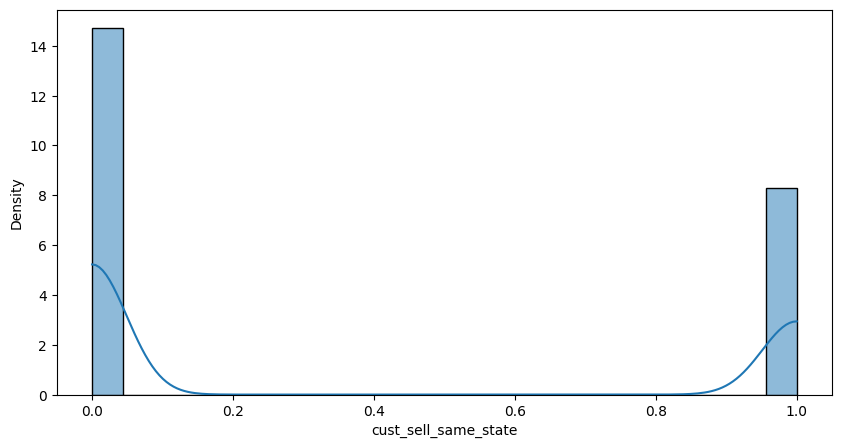

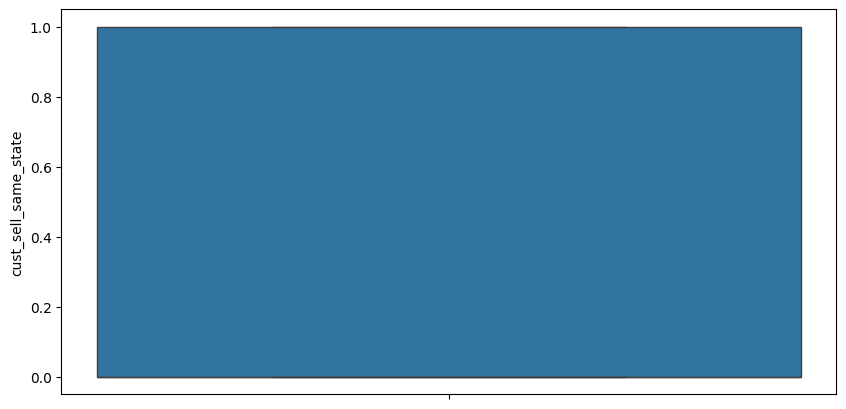

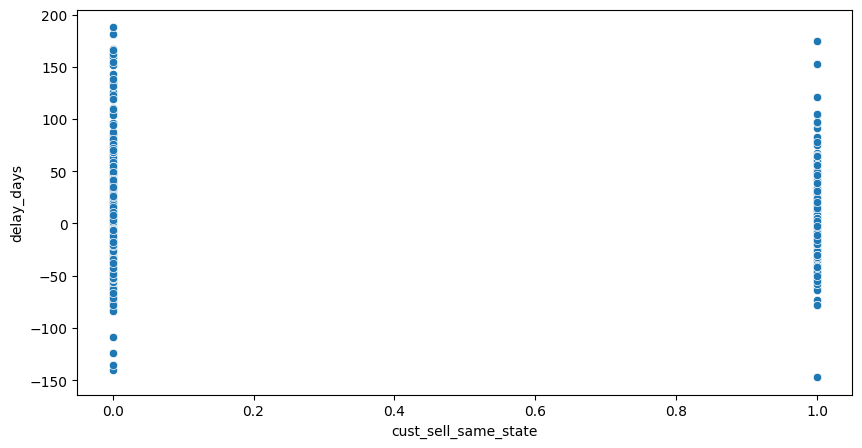

In [125]:
quick_viz(df.cust_sell_same_state)

In [126]:
df.cust_sell_same_state.value_counts()

cust_sell_same_state
False    58543
True     32932
Name: count, dtype: int64

> We see that we get less extreme delays (positive or negative) if the customer and seller are from the same state. Although, we would probably expect to see fewer delays in general when customer and seller are int the same state

**customer_lat**

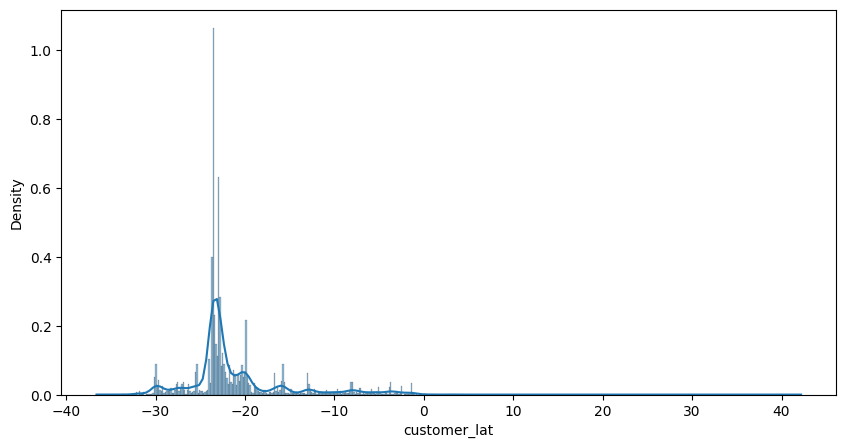

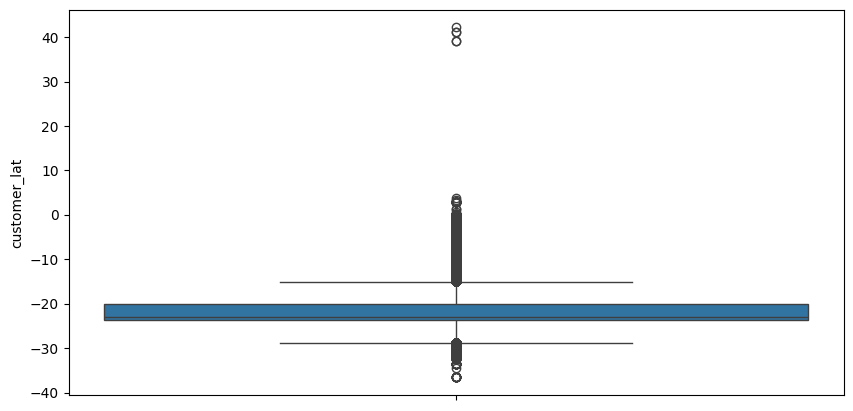

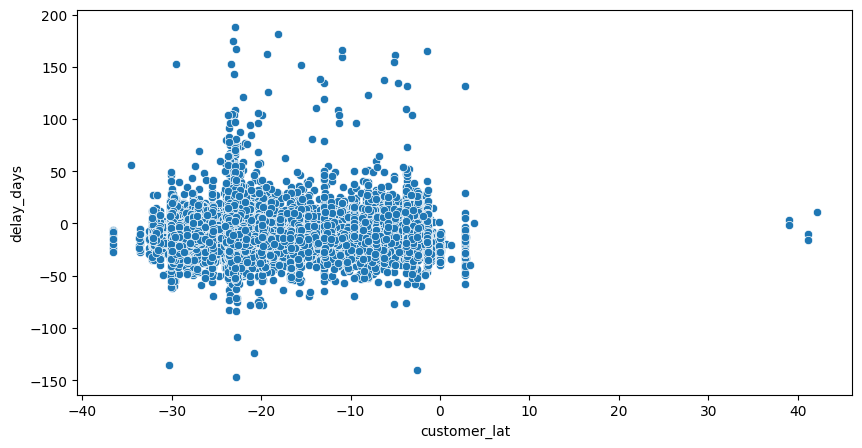

In [127]:
quick_viz(df.customer_lat)

**

# Target analysis 

# Feature ranking options